In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.optimize as so
import scipy.stats as ss
from scipy.special import gamma as gammaf
from scipy.special import loggamma
import statsmodels.api as sm
from scipy import interpolate
import matplotlib
import random
import copy
import json
import toml
import math
import sys

from tqdm import tqdm
from tqdm.notebook import trange,tqdm_notebook

matplotlib.rc('font', **{'family' : 'normal','size'   : 10})
# %matplotlib notebook

# Generate data

In [2]:
np.random.seed(2021)
# Get number of data
n = 500

# Generate rho
rho = np.linspace(0.01,50,n)
#np.concatenate([np.linspace(0.01,5,5),np.linspace(5,20,35),np.linspace(20,100,10)])

# Define exponential fundamental diagram
def exponential_fd(p):
    return p[0]*rho*np.exp(-p[1]*rho)

# Decide on parameters
alpha = 0.6 # 0.2, 0.6
beta = 0.1 # 0.02, 0.1
# Define noise
sigma2 = 0.0001#0.00005 # 0.05, 0.1
true_params = [alpha,beta,sigma2]

# Simulate q 
q_true = exponential_fd([alpha,beta])
noise = np.random.multivariate_normal(np.zeros(len(q_true)),np.eye(len(q_true))*sigma2)
q = q_true*np.exp(noise)

# q = np.array([np.random.lognormal(mean = np.log(q_true[i]), sigma = np.sqrt(sigma2)) for i in range(len(q_true))])
# noise = np.random.multivariate_normal(np.zeros(n),np.eye(n)*sigma2)
# q2 = q_true*np.exp(noise)

## Plot generated data

In [3]:
# q_hat = exponential_fd([0.6003084518474716,0.0999726807846394,sigma2])

# #exponential_fd(np.mean(grw_mcmc_parameters[burnin:,:],axis=0))
# %matplotlib notebook
# plt.figure(figsize=(10,10))
# plt.scatter(rho,q)
# # plt.plot(rho,q_hat,color='r',label=f'estimated')
# plt.plot(rho,q_true,color='b',label='true')
# plt.xlabel(r'$\rho$')
# plt.ylabel(r'$q$')
# plt.legend()
# plt.ioff()

<IPython.core.display.Javascript object>


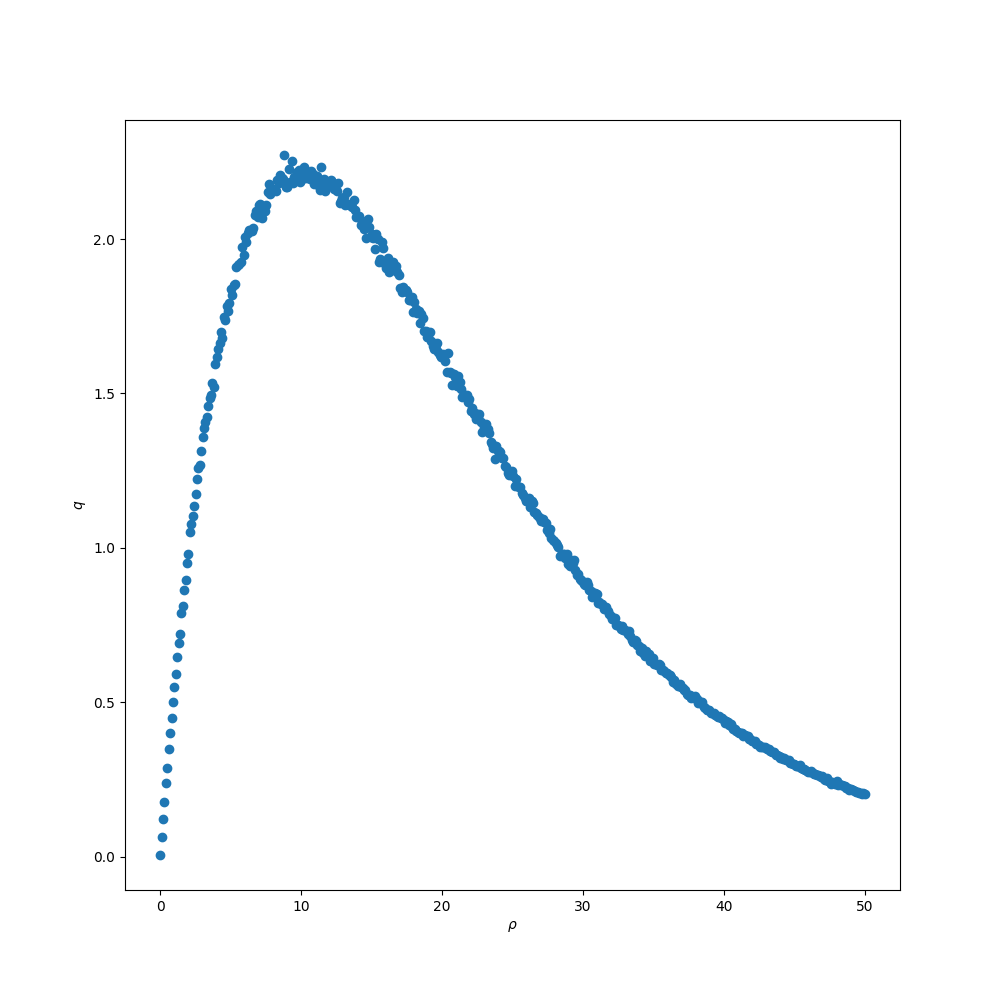

Text(0, 0.5, '$q$')

In [4]:
%matplotlib notebook
plt.figure(figsize=(10,10))
plt.scatter(rho,q)
plt.xlabel(r'$\rho$')
plt.ylabel(r'$q$')

## Get acceptable ranges for alpha,beta

In [5]:
print(f'alpha = {alpha}, beta = {beta}')

alpha = 0.6, beta = 0.1


In [6]:
# alpha_upper = 0.4#0.23, 0.65
# beta_upper = 0.3#0.023, 0.12

# alpha_lower = 0.2#0.17, 0.55
# beta_lower = 0.2#0.017, 0.09
    
# q_upper = exponential_fd([alpha_upper,beta_lower])
# q_lower = exponential_fd([alpha_lower,beta_upper])

In [7]:
# plt.figure(figsize=(10,10))
# plt.scatter(rho,q)
# plt.plot(rho,q_lower,color='r',label=f'upper bound (alpha={alpha_upper},beta={beta_lower})')
# plt.plot(rho,q_true,color='b',label='true')
# plt.plot(rho,q_upper,color='r',label=f'lower bound (alpha={alpha_lower},beta={beta_upper})')
# plt.xlabel(r'$\rho$')
# plt.ylabel(r'$q$')
# plt.legend()
# plt.show()

# Parameter estimation via constrained OLS

In [8]:
# Initial parameter guess
alpha0 = 0.2
beta0 = 0.05
p0 = (alpha0, beta0) 

def exponential_fd_param_squared_error(p):
    return np.sum((q-exponential_fd(p))**2)

def exponential_fd_param_hessian(p):
    _a = p[0]
    _b = p[1]
    return _a*_b**2*rho*np.exp(-_b*rho)-2*_a*_b*np.exp(-_b*rho)

# Define constraints on positivty and concavity
positivity_constraint = so.NonlinearConstraint(exponential_fd,np.ones(len(rho))* np.inf,np.zeros(len(rho)))
concavity_constraint = so.NonlinearConstraint(exponential_fd_param_hessian,np.ones(len(rho))* -np.inf,np.zeros(len(rho)))

# Optimise parameters for least squares
constrained_ls = so.minimize(exponential_fd_param_squared_error, p0, constraints=[positivity_constraint,concavity_constraint],method='BFGS')
constrained_ls_params = constrained_ls.x
constrained_ls_q_hat = exponential_fd(constrained_ls_params)

print(f'Constrained LS alpha = {constrained_ls_params[0]}, beta={constrained_ls_params[1]}, squared error = {int(constrained_ls.fun)}')
print(f'True alpha = {alpha}, beta={beta}')

Constrained LS alpha = 0.6013027873680235, beta=0.10008268369950485, squared error = 0
True alpha = 0.6, beta=0.1


/Users/Yannis/.pyenv/versions/3.7.5/envs/ptfm/lib/python3.7/site-packages/scipy/optimize/_minimize.py:536: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  RuntimeWarning)


# Parameter estimation via Marginal Likelihood Estimation

We employ three models



We look at [this paper](https://www.sciencedirect.com/science/article/pii/S0167947309002722) and implement a population MCMC for marginal likelihood estimation.

## Vanilla Metropolis Hastings 

In [9]:
# Define base URL
base_url = '../data/input/inference_parameters'
# Define inference method
method = 'vanilla_mcmc'

# # Define filename
filename = f'grwmh_inference_wide_gamma_priors_sigma2_fixed_smaller_more_data'

# Flag for loading data
load_data = True

In [10]:
# Fix random seed
np.random.seed(2021)
# Define number of parameters
num_params = 3
# Define parameter names
param_names = [r'$\alpha$',r'$\beta$',r'$\sigma$']
# Flag for initiliasing parameters by randomly sampling from priors (except for noise sigma2)
# If True it initialises parameters on OLS solution (except for noise sigma2)
random_initialisation = False

if not load_data:
    # Define number of iterations of each temperature chain
    N = 10000
    # Define beta step
    beta_step = 0.01
    # Prior alpha hyperparameter for Beta prior of alpha parameter
    prior_a_alpha_param = 2.#6.6#6.2#1.
    # Prior beta hyperparameter for Beta prior of alpha parameter
    prior_b_alpha_param = 0.3#4.4#24.8#4.
    # Prior alpha hyperparameter for Beta prior of beta parameter
    prior_a_beta_param = 2.#4.4#1.286666667#1.
    # Prior beta hyperparameter for Beta prior of beta parameter
    prior_b_beta_param = 0.05#39.6#63.046666667#11.
    # Define parameter proposal covariance
    proposal_covariance = np.diag([0.01,0.001,0]) 

    # Generate pairs of (alpha,beta) from Beta(1,2) prior
    parameters_init = np.zeros(num_params)
    if random_initialisation:
        parameters_init[0] = np.random.gamma(prior_a_alpha_param,prior_b_alpha_param,1)
        parameters_init[1] = np.random.gamma(prior_a_beta_param,prior_b_beta_param,1)
        # Gamma prior for unknown observation noise
        parameters_init[2] = sigma2
    else:
#         parameters_init[0] = alpha
#         parameters_init[1] = beta
#         parameters_init[2] = sigma2
        parameters_init = [0.4,0.2,sigma2]
        
else:
    # Load metadata
    grw_posterior_metadata = toml.load((base_url+'/'+filename+'.toml'))
    
    
    # Define number of iterations of each temperature chain
    N = int(grw_posterior_metadata['inference'][method]['N'])
    # Define beta step
    beta_step = float(grw_posterior_metadata['inference'][method]['transition_kernel']['beta_step'])
    # Prior alpha hyperparameter for Beta prior of parameters except observation noise
    prior_a_alpha_param = float(grw_posterior_metadata['inference']['priors']['alpha']['a'])
    # Prior alpha hyperparameter for Beta prior of parameters except observation noise
    prior_a_beta_param = float(grw_posterior_metadata['inference']['priors']['beta']['a'])
    # Prior beta hyperparameter for Beta prior of alpha parameter
    prior_b_alpha_param = float(grw_posterior_metadata['inference']['priors']['alpha']['scale'])
    # Prior beta hyperparameter for Beta prior of beta parameter
    prior_b_beta_param = float(grw_posterior_metadata['inference']['priors']['beta']['scale'])
    # Define parameter proposal covariance
    proposal_covariance = list(grw_posterior_metadata['inference'][method]['transition_kernel']['K_diagonal'])
    proposal_covariance.append(0)
    proposal_covariance = np.diag(proposal_covariance)
    # Generate pairs of (alpha,beta) from Beta(1,2) prior
    parameters_init = list(grw_posterior_metadata['inference'][method]['p0'])
    parameters_init.append(sigma2)
    
print('Proposal covariance')
print(proposal_covariance)

print(fr'Initial alpha={parameters_init[0]}, beta={parameters_init[1]},sigma^2={parameters_init[2]}')

Proposal covariance
[[1.25e-03 0.00e+00 0.00e+00]
 [0.00e+00 1.25e-05 0.00e+00]
 [0.00e+00 0.00e+00 0.00e+00]]
Initial alpha=0.4, beta=0.2,sigma^2=0.0001


#### Prior visualisation

<IPython.core.display.Javascript object>


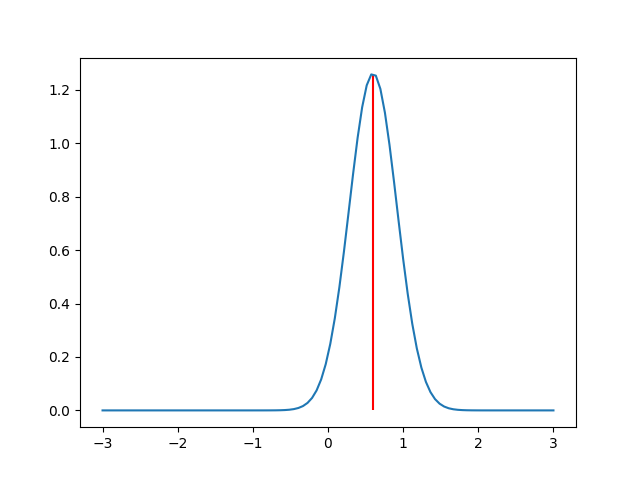

In [11]:
%matplotlib notebook
alpha1 = np.linspace(-3,3,100)
palpha1 = ss.norm.pdf(alpha1,loc=0.6,scale=np.sqrt(0.1))
plt.vlines(ss.norm.mean(loc=.6,scale=np.sqrt(0.1)),np.min(palpha1),np.max(palpha1),color='red')
plt.plot(alpha1,palpha1)

<IPython.core.display.Javascript object>


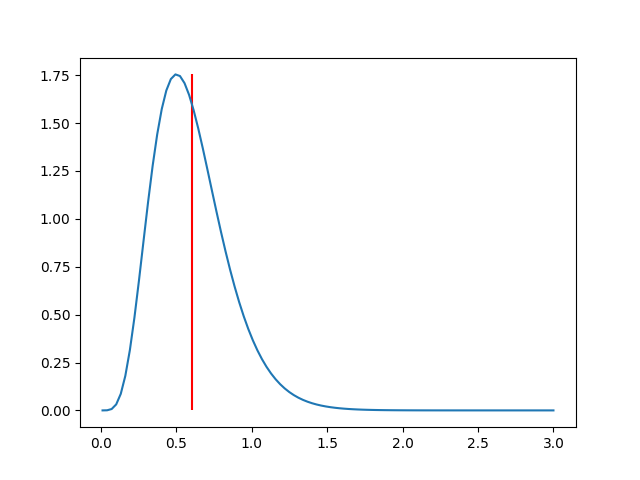

In [24]:
%matplotlib notebook
alpha1 = np.linspace(0.01,3,100)
palpha1 = ss.gamma.pdf(alpha1,a=6.,scale=0.1)
plt.vlines(ss.gamma.mean(a=6.,scale=0.1),np.min(palpha1),np.max(palpha1),color='red')
plt.plot(alpha1,palpha1)

In [18]:
def log_prior_transformed(p):
    p_trans = np.log(p)
    a = 6.
    scale = 0.1
    b = 1./scale
    alpha_prior_logpdf = a*np.log(b) - loggamma(a) + a*p_trans - b*np.exp(p_trans)
    return alpha_prior_logpdf

In [386]:
from scipy.special import erf

In [ ]:
%matplotlib notebook
alpha1 = np.linspace(-0.1,2,100)
palpha1 = ss.lognorm.pdf(alpha1,a=0,b=1e9,loc=0,scale=np.sqrt(0.1))
plt.plot(alpha1,palpha1)
plt.vlines(0.6,np.min(palpha1),np.max(palpha1),color='black')
plt.vlines(ss.truncnorm.mean(a=0,b=1e9,loc=0.35,scale=np.sqrt(0.1)),np.min(palpha1),np.max(palpha1),color='red')

<IPython.core.display.Javascript object>


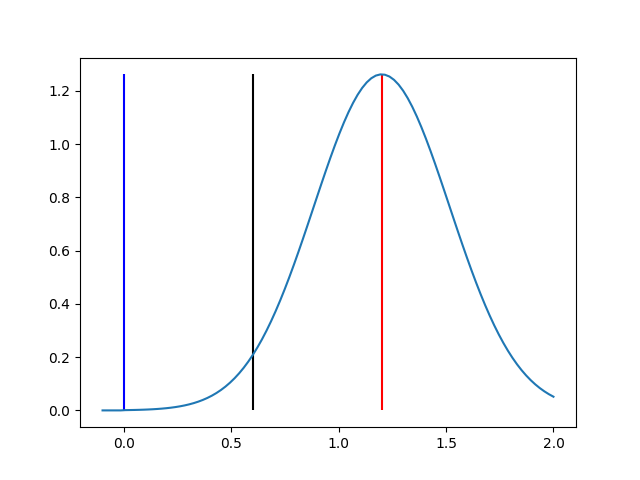

In [45]:
%matplotlib notebook
sig = np.sqrt(0.1)#0.6 - 2/(np.sqrt(2*np.pi))
location = 1.2
a = -location/sig
b = (1e9-location)/sig
alpha1 = np.linspace(-0.1,2,100)
palpha1 = ss.truncnorm.pdf(alpha1,a=a,b=b,loc=location,scale=sig)
plt.plot(alpha1,palpha1)
plt.vlines(0.6,np.min(palpha1),np.max(palpha1),color='black')
plt.vlines(0,np.min(palpha1),np.max(palpha1),color='blue')
plt.vlines(ss.truncnorm.mean(a=a,b=b,loc=location,scale=sig),np.min(palpha1),np.max(palpha1),color='red')

<IPython.core.display.Javascript object>


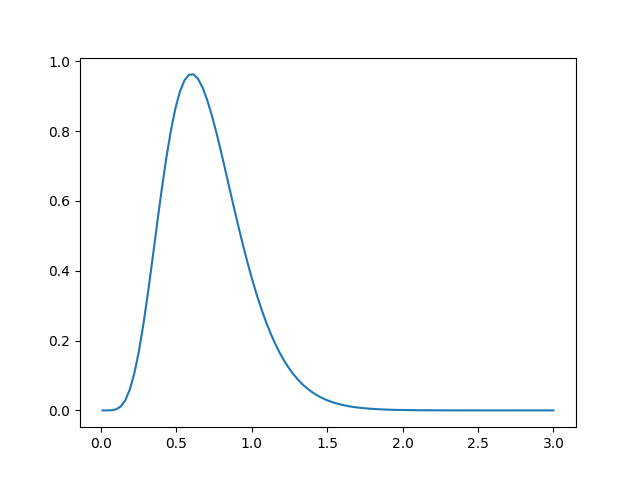

In [19]:
%matplotlib notebook
alpha1 = np.linspace(0.01,3,100)
palpha1 = np.exp(log_prior_transformed(alpha1))
plt.plot(alpha1,palpha1)

<IPython.core.display.Javascript object>


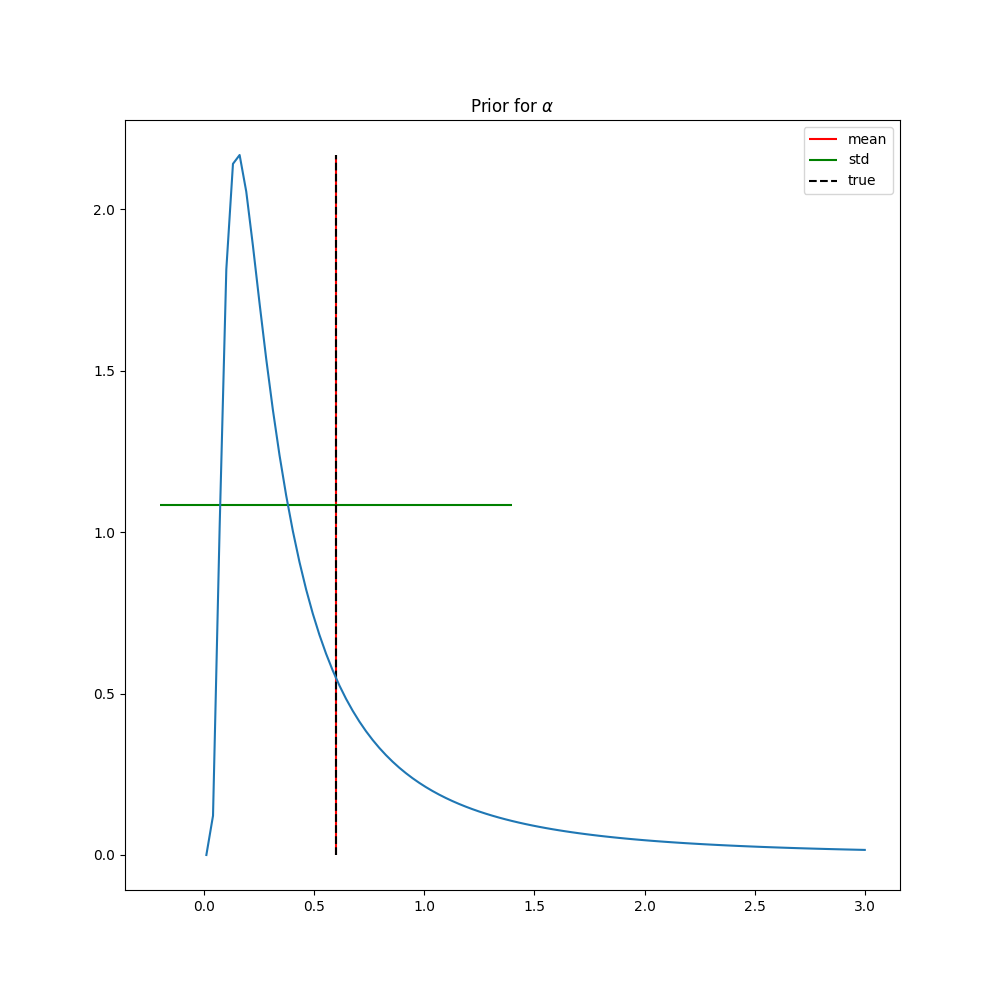

<IPython.core.display.Javascript object>


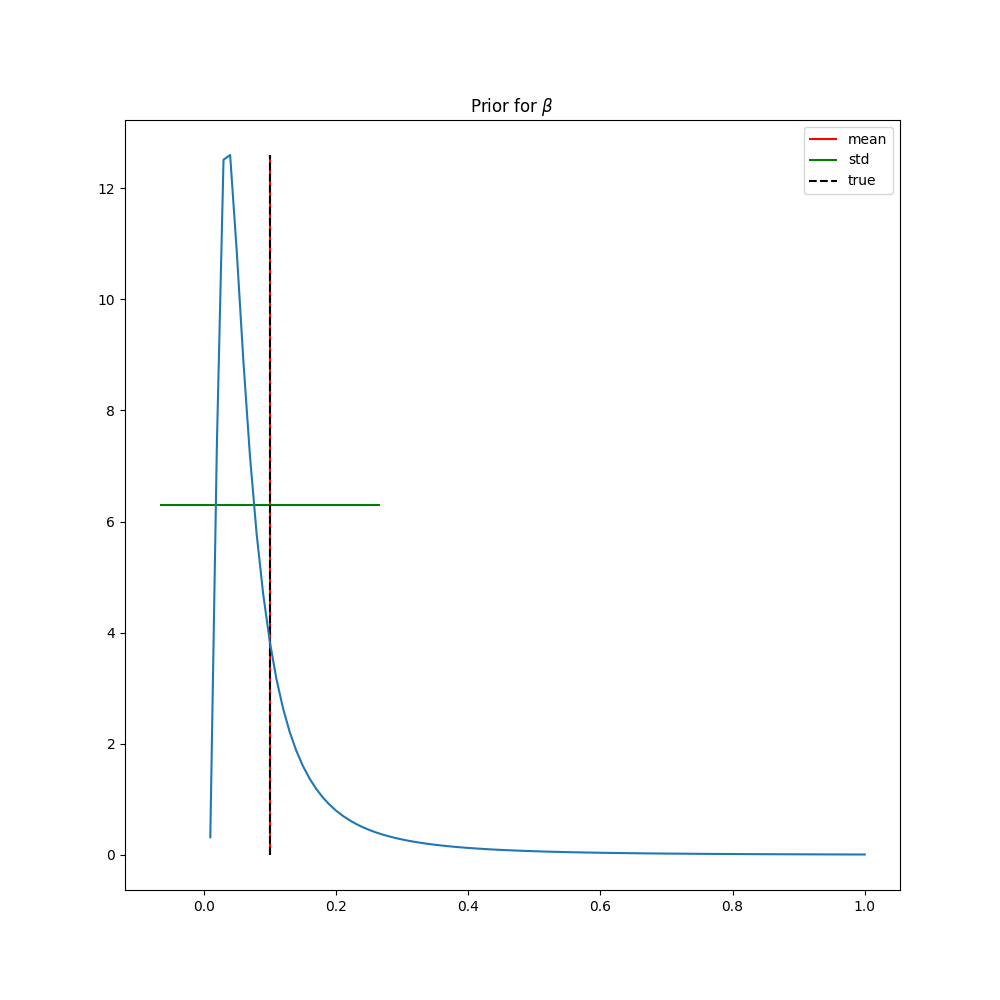

In [279]:
plt.figure(figsize=(10,10))
alpha1 = np.linspace(0.01,3,100)
palpha1 = ss.geninvgauss.pdf(alpha1,p=-1,b=0.61)#ss.geninvgauss.pdf(alpha1,p=-2,b=2.42)
#ss.gamma.pdf(alpha1,prior_a_alpha_param,scale=prior_b_alpha_param)
plt.plot(alpha1,palpha1)
alpha_prior_mean = ss.geninvgauss.mean(p=-1,b=0.61)#ss.geninvgauss.mean(p=-2,b=2.42)
#ss.gamma.mean(prior_a_alpha_param,scale=prior_b_alpha_param)
alpha_prior_std = ss.geninvgauss.std(p=-1,b=0.61)#ss.geninvgauss.std(p=-2,b=2.42)
#ss.gamma.std(prior_a_alpha_param,scale=prior_b_alpha_param)
plt.vlines(alpha_prior_mean,ymin=0,ymax=np.max(palpha1[np.isfinite(palpha1)]),color='red',label='mean')
# plt.annotate(text='', xy=((alpha_prior_mean),np.max(palpha1)/2), xytext=((alpha_prior_mean+alpha_prior_std),np.max(palpha1)/2), arrowprops=dict(arrowstyle='<-',color='green',label='std'))
plt.hlines(np.max(palpha1)/2,xmin=(alpha_prior_mean-alpha_prior_std),xmax=(alpha_prior_mean+alpha_prior_std),color='green',label='std')
plt.vlines(alpha,ymin=0,ymax=np.max(palpha1[np.isfinite(palpha1)]),color='black',label='true',linestyle='dashed')
plt.title(r'Prior for $\alpha$')
plt.legend()
plt.show()


plt.figure(figsize=(10,10))
beta1 = np.linspace(0.01,1,100)
pbeta1 = ss.geninvgauss.pdf(beta1,p=-2,b=0.209)
#ss.gamma.pdf(beta1,prior_a_beta_param,scale=prior_b_beta_param)
beta_prior_mean = ss.geninvgauss.mean(p=-2,b=0.209)
#ss.gamma.mean(prior_a_beta_param,scale=prior_b_beta_param)
beta_prior_std = ss.geninvgauss.std(p=-2,b=0.209)
#ss.gamma.std(prior_a_beta_param,scale=prior_b_beta_param)
plt.plot(beta1,pbeta1)
plt.vlines(beta_prior_mean,ymin=0,ymax=np.max(pbeta1[np.isfinite(pbeta1)]),color='red',label='mean')
plt.hlines(np.max(pbeta1)/2,xmin=(beta_prior_mean-beta_prior_std),xmax=(beta_prior_mean+beta_prior_std),color='green',label='std')
plt.vlines(beta,ymin=0,ymax=np.max(pbeta1[np.isfinite(pbeta1)]),color='black',label='true',linestyle='dashed')
plt.title(r'Prior for $\beta$')
plt.legend()
plt.show()

# if proposal_covariance[2,2] > 0:
#     x1 = np.linspace(0.01,10,100)
#     y1 = ss.gamma.pdf(x1,a=gamma_prior_a_sigma_param,scale=gamma_prior_b_sigma_param)
#     plt.plot(x1,y1)
#     plt.vlines(gamma_prior_a_sigma_param*gamma_prior_b_sigma_param,ymin=0,ymax=np.max(y1[~np.isnan(y1)]),color='red',label='mean')
#     plt.title('Gamma prior')
#     plt.legend()
#     plt.show()

### Define key functions

In [166]:
# Define exponential fundamental diagram
def exponential_fd_with_rho(p,_rho):
    return p[0]*_rho*np.exp(-p[1]*_rho)

def lognorm_log_distr(x,m,s2):
    return -np.log(x) - np.log(np.sqrt(s2*2*np.pi)) - (np.log(x)-m)**2/(2*s2)

# Vanilla Metropolis Hastings MCMC
def exponential_fd_log_prior_scipy(p):
    return ss.gamma.logpdf(p[0],prior_a_alpha_param,scale=prior_b_alpha_param) + ss.gamma.logpdf(p[1],prior_a_beta_param,scale=prior_b_beta_param)

def exponential_fd_log_prior(p):
    alpha_prior = -np.log(gammaf(prior_a_alpha_param)) + prior_a_alpha_param*np.log(1/prior_b_alpha_param) + (prior_a_alpha_param-1)*np.log(p[0]) - (1/prior_b_alpha_param)*p[0]
    beta_prior = -np.log(gammaf(prior_a_beta_param)) + prior_a_beta_param*np.log(1/prior_b_beta_param) + (prior_a_beta_param-1)*np.log(p[1]) - (1/prior_b_beta_param)*p[1]
    return alpha_prior + beta_prior

def exponential_fd_log_likelihood_lognorm(p,y,x):
    return np.sum([lognorm_log_distr(y[i],np.log(exponential_fd_with_rho(p[:-1],x[i])),p[-1]) for i in range(len(y))])
#     return (np.sum([ss.lognorm.logpdf(x=y[i],s=np.sqrt(p[-1]),scale=exponential_fd(p[:-1])[i]) for i in range(y.shape[0])]))# - np.sum(np.log(y)))

def exponential_fd_log_likelihood_norm(p,y):
#     Covc = np.linalg.cholesky(((p[-1]+ 1e-6)*np.eye(k)))
#     Covc_inv = np.linalg.inv(Covc)
#     Cov_inv = np.dot(Covc_inv.T,Covc_inv)
    k = len(y)
#     print('Cov_det',log_Cov_det)
    return -0.5*k*np.log(2*np.pi)-0.5*k*np.log(sigma2)-0.5*(1/(p[-1])) * ( ( np.log(y)-np.log(exponential_fd(p[:-1])) ) @ ( np.log(y)-np.log(exponential_fd(p[:-1])) ).T ) - np.sum(np.log(y))

def exponential_fd_log_target(p,y):
    # Log target is sum of priors and likelihood for each temperature
    return exponential_fd_log_prior(p) + exponential_fd_log_likelihood_norm(p,y)

def gaussian_transition_kernel(p_prev,_beta,_cov):
    # Propose move
    return p_prev + _beta*ss.multivariate_normal.rvs(np.zeros(p_prev.shape[0]),_cov)

def exponential_fd_log_likelihood_norm_with_rho(p,y,r):
    k = len(y)
#     return -0.5*k*np.log(2*np.pi)-0.5*k*np.log(p[-1])-0.5*(1/(p[-1])) * ( ( np.log(y)-np.log(exponential_fd_with_rho(p[:-1],r)) ) @ ( np.log(y)-np.log(exponential_fd_with_rho(p[:-1],r)) ).T ) - np.sum(np.log(y))
    _q = exponential_fd_with_rho(p[:-1],r)
    exp_mean = _q / np.sqrt(1 + p[-1])
    mean = np.log(exp_mean)
    var = np.log(1 + p[-1])
    stdev = np.sqrt(var)
    return((ss.multivariate_normal.logpdf(np.log(y),mean=mean,cov=np.eye(k)*var) - np.sum(np.log(y))))
    
def exponential_fd_log_target_with_rho(p,y,r):
    # Log target is sum of priors and likelihood for each temperature
    return exponential_fd_log_prior(p) + exponential_fd_log_likelihood_norm_with_rho(p,y,r)

def neg_log_target(p,*args):
    _sigma2 = args[0]
    _q = args[1]
    _r = args[2]
    p_with_sigma = [p[0],p[1],_sigma2]
    return -exponential_fd_log_target_with_rho(p_with_sigma,_q,_r)

def neg_log_likelihood(p,*args):
    _sigma2 = args[0]
    _q = args[1]
    _r = args[2]
    p_with_sigma = [p[0],p[1],_sigma2]
    return -exponential_fd_log_likelihood_norm_with_rho(p_with_sigma,_q,_r)

### Make sure functions are correct

In [13]:
np.sum([lognorm_log_distr(q[i],np.log(exponential_fd_with_rho([alpha,beta],rho[i])),sigma2) for i in range(len(q))])

1654.9860054302035

In [14]:
np.sum([ ss.lognorm.logpdf(x=q[i],s=np.sqrt(sigma2),scale=exponential_fd_with_rho([alpha,beta],rho[i])) for i in range(len(q))])

1654.9860054302035

In [15]:
exponential_fd_log_likelihood_lognorm([alpha,beta,sigma2],q,rho)

1654.9860054302035

In [16]:
(np.sum([ss.lognorm.logpdf(x=q[i],s=np.sqrt(sigma2),scale=exponential_fd([alpha,beta])[i]) for i in range(q.shape[0])]))

1654.9860054302035

In [17]:
exponential_fd_log_likelihood_norm([alpha,beta,sigma2],q)

1654.9860054302035

In [18]:
ss.multivariate_normal.logpdf(np.log(q),mean=np.log(exponential_fd([alpha,beta])),cov=sigma2*np.eye(len(q))) - np.sum(np.log(q))

1654.986005430203

In [19]:
exponential_fd_log_prior_scipy([alpha,beta])

2.162770150466211

In [20]:
exponential_fd_log_prior([alpha,beta])

2.1627701504662116

In [21]:
exponential_fd_log_target([alpha,beta,sigma2],q)

1657.1487755806697

In [22]:
exponential_fd_log_target_with_rho([alpha,beta,sigma2],q,rho)

1657.1487755806697

In [23]:
neg_log_target([alpha,beta],sigma2,q,rho)

-1657.1487755806697

## Debug data simulation 

In [24]:
# Decide on parameters
alpha = 0.6 # 0.2, 0.6
beta = 0.1 # 0.02, 0.1
# Define noise
sigma2 = 0.0001#0.00005 # 0.05, 0.1
true_params = [alpha,beta,sigma2]
p0_lt = [alpha,beta]
current_seed = 2021
minn = 10
maxn = 800
nsteps = 10
dataset_sizes = range(minn,maxn,nsteps)
dataset_sizes_arr = np.array(list(dataset_sizes))

# opt_params,opt_params2,opt_params3,opt_params4 = {"params":[],"log_target":[],"log_target_true":[]},{"params":[],"log_target":[],"log_target_true":[]},{"params":[],"log_target":[],"log_target_true":[]},{"params":[],"log_target":[],"log_target_true":[]}
# for _n in tqdm(dataset_sizes):
#     # Generate rho
#     simrho = np.linspace(0.01,50,_n)

#     # Simulate q 
#     simq_true = exponential_fd_with_rho([alpha,beta],simrho)
    
#     # Simulate q in two ways
#     # Method 1
#     np.random.seed(current_seed)
#     simq = np.array([np.random.lognormal(mean = np.log(simq_true[i]), sigma = np.sqrt(sigma2)) for i in range(len(simq_true))])
#     # Method 2
#     np.random.seed(current_seed)
#     simnoise = np.random.multivariate_normal(np.zeros(_n),np.eye(_n)*sigma2)
#     simq2 = simq_true*np.exp(simnoise)
#     # Method 3
#     np.random.seed(current_seed)
#     simq3 = ss.lognorm.rvs(np.sqrt(sigma2),0,simq_true)
#     # Method 4 
#     np.random.seed(current_seed)
#     simnoise4 = ss.multivariate_normal.rvs(mean=np.zeros(_n),cov=sigma2*np.eye(_n))
#     simq4 = simq_true*np.exp(simnoise4)
    
#     log_target_ls = so.minimize(neg_log_target, p0_lt, args=(simq,simrho))
#     log_target_ls_params = log_target_ls.x
#     opt_params['params'].append(log_target_ls_params)
#     opt_params['log_target'].append(neg_log_target(log_target_ls_params,simq,simrho))
#     opt_params['log_target_true'].append(neg_log_target([alpha,beta,sigma2],simq,simrho))
    
#     log_target_ls2 = so.minimize(neg_log_target, p0_lt, args=(simq2,simrho))
#     log_target_ls2_params = log_target_ls2.x
#     opt_params2['params'].append(log_target_ls2_params)
#     opt_params2['log_target'].append(neg_log_target(log_target_ls2_params,simq2,simrho))
#     opt_params2['log_target_true'].append(neg_log_target([alpha,beta,sigma2],simq2,simrho))
    
#     log_target_ls3 = so.minimize(neg_log_target, p0_lt, args=(simq3,simrho))
#     log_target_ls3_params = log_target_ls3.x
#     opt_params3['params'].append(log_target_ls3_params)
#     opt_params3['log_target'].append(neg_log_target(log_target_ls3_params,simq3,simrho))
#     opt_params3['log_target_true'].append(neg_log_target([alpha,beta,sigma2],simq3,simrho))
    
#     log_target_ls4 = so.minimize(neg_log_target, p0_lt, args=(simq4,simrho))
#     log_target_ls4_params = log_target_ls4.x
#     opt_params4['params'].append(log_target_ls4_params)
#     opt_params4['log_target'].append(neg_log_target(log_target_ls4_params,simq4,simrho))
#     opt_params4['log_target_true'].append(neg_log_target([alpha,beta,sigma2],simq4,simrho))

# opt_params['params'] = np.array(opt_params['params'])
# opt_params2['params'] = np.array(opt_params2['params'])
# opt_params3['params'] = np.array(opt_params3['params'])
# opt_params4['params'] = np.array(opt_params4['params'])

<IPython.core.display.Javascript object>


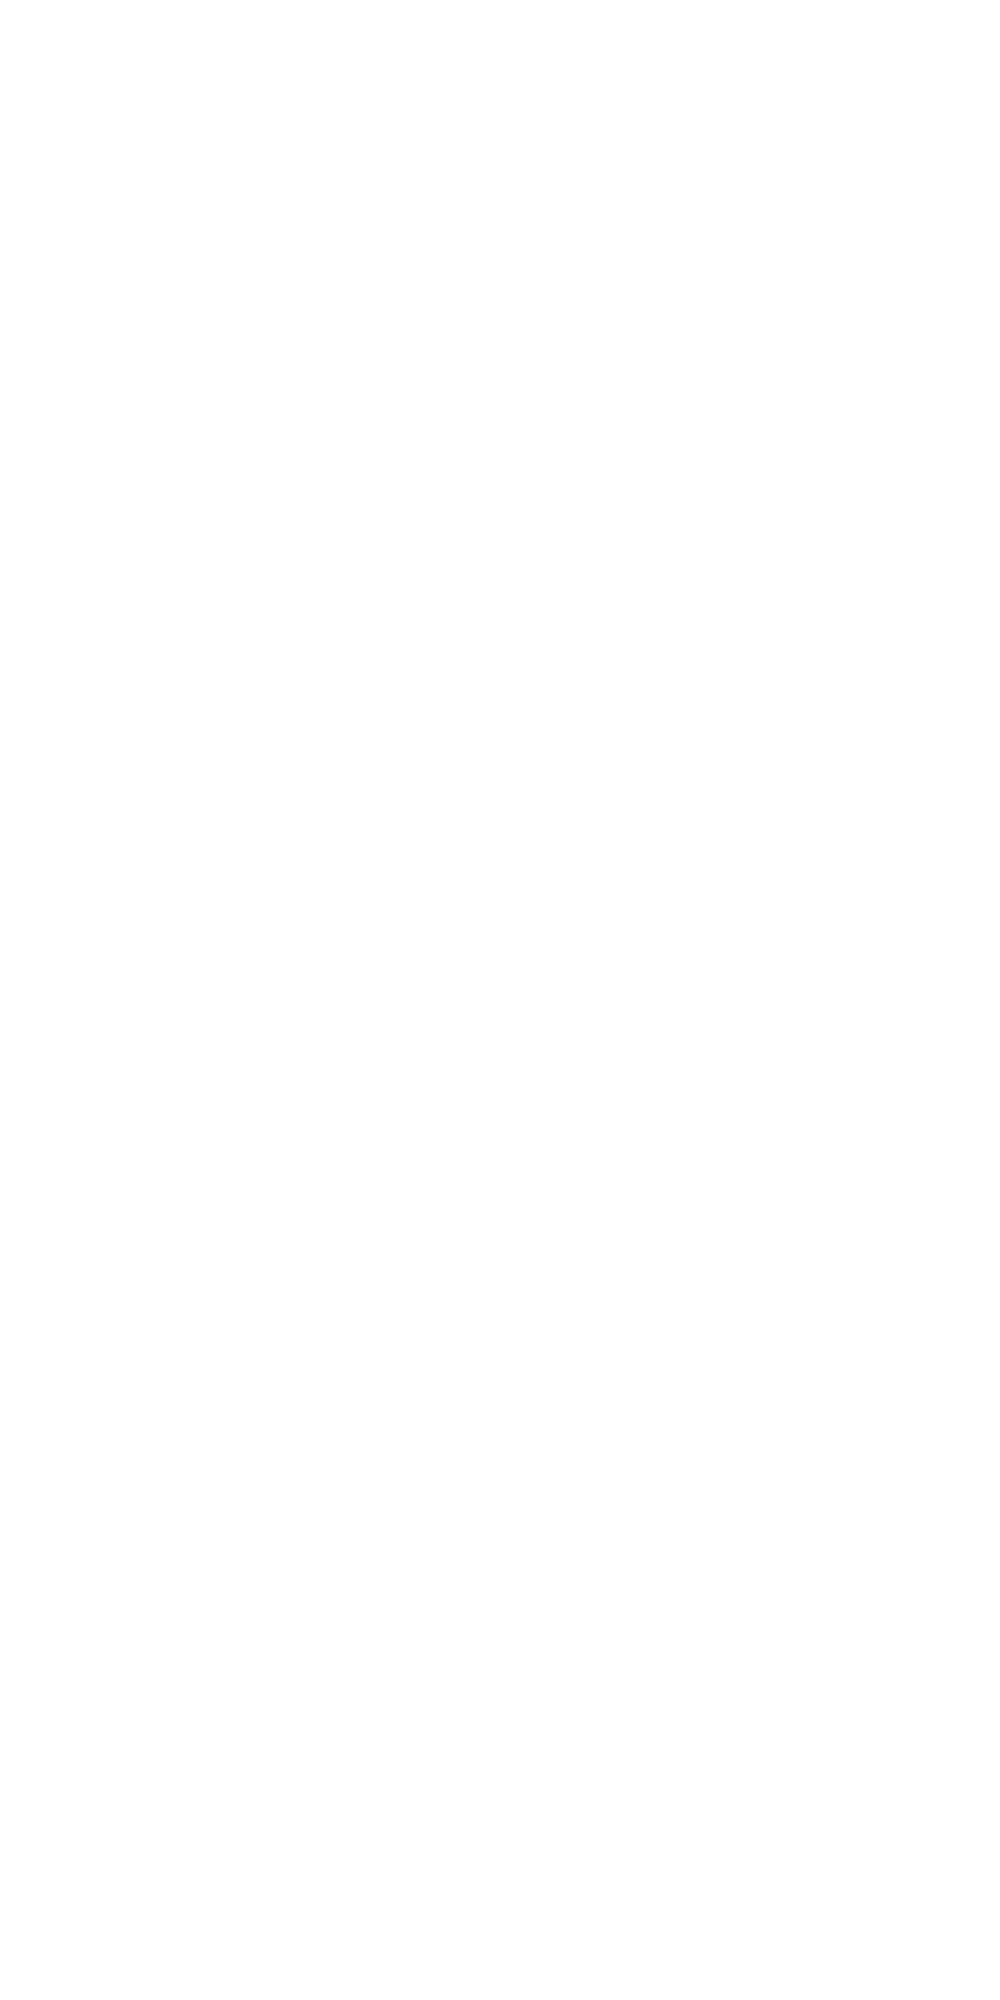

NameError: name 'opt_params' is not defined

In [25]:
fig, ax = plt.subplots(nrows=4, ncols=2,figsize=(10,20))

plt.subplot(4,2,1)
plt.title(r'Method 1 $\alpha$ parameter')
plt.plot(dataset_sizes,opt_params['params'][:,0],color='red',label='MLE',zorder=1)
plt.hlines(alpha,minn,maxn,color='blue',label='True',zorder=2)
plt.ylabel(r'$\alpha$')
plt.xlabel('Simulated dataset size')

plt.subplot(4,2,2)
plt.title(r'Method 1 $\beta$ parameter')
plt.plot(dataset_sizes,opt_params['params'][:,1],color='red',label='MLE',zorder=1)
plt.hlines(beta,minn,maxn,color='blue',label='True',zorder=2)
plt.ylabel(r'$\beta$')
plt.xlabel('Simulated dataset size')

plt.subplot(4,2,3)
plt.title(r'Method 2 $\alpha$ parameter')
plt.plot(dataset_sizes,opt_params2['params'][:,0],color='red',label='MLE',zorder=1)
plt.hlines(alpha,minn,maxn,color='blue',label='True',zorder=2)
plt.ylabel(r'$\alpha$')
plt.xlabel('Simulated dataset size')

plt.subplot(4,2,4)
plt.title(r'Method 2 $\beta$ parameter')
plt.plot(dataset_sizes,opt_params2['params'][:,1],color='red',label='MLE',zorder=1)
plt.hlines(beta,minn,maxn,color='blue',label='True',zorder=2)
plt.ylabel(r'$\beta$')
plt.xlabel('Simulated dataset size')

plt.subplot(4,2,5)
plt.title(r'Method 3 $\alpha$ parameter')
plt.plot(dataset_sizes,opt_params3['params'][:,0],color='red',label='MLE',zorder=1)
plt.hlines(alpha,minn,maxn,color='blue',label='True',zorder=2)
plt.ylabel(r'$\alpha$')
plt.xlabel('Simulated dataset size')

plt.subplot(4,2,6)
plt.title(r'Method 3 $\beta$ parameter')
plt.plot(dataset_sizes,opt_params3['params'][:,1],color='red',label='MLE',zorder=1)
plt.hlines(beta,minn,maxn,color='blue',label='True',zorder=2)
plt.ylabel(r'$\beta$')
plt.xlabel('Simulated dataset size')

plt.subplot(4,2,7)
plt.title(r'Method 4 $\alpha$ parameter')
plt.plot(dataset_sizes,opt_params4['params'][:,0],color='red',label='MLE',zorder=1)
plt.hlines(alpha,minn,maxn,color='blue',label='True',zorder=2)
plt.ylabel(r'$\alpha$')
plt.xlabel('Simulated dataset size')

plt.subplot(4,2,8)
plt.title(r'Method 4 $\beta$ parameter')
plt.plot(dataset_sizes,opt_params4['params'][:,1],color='red',label='MLE',zorder=1)
plt.hlines(beta,minn,maxn,color='blue',label='True',zorder=2)
plt.ylabel(r'$\beta$')
plt.xlabel('Simulated dataset size')

<IPython.core.display.Javascript object>


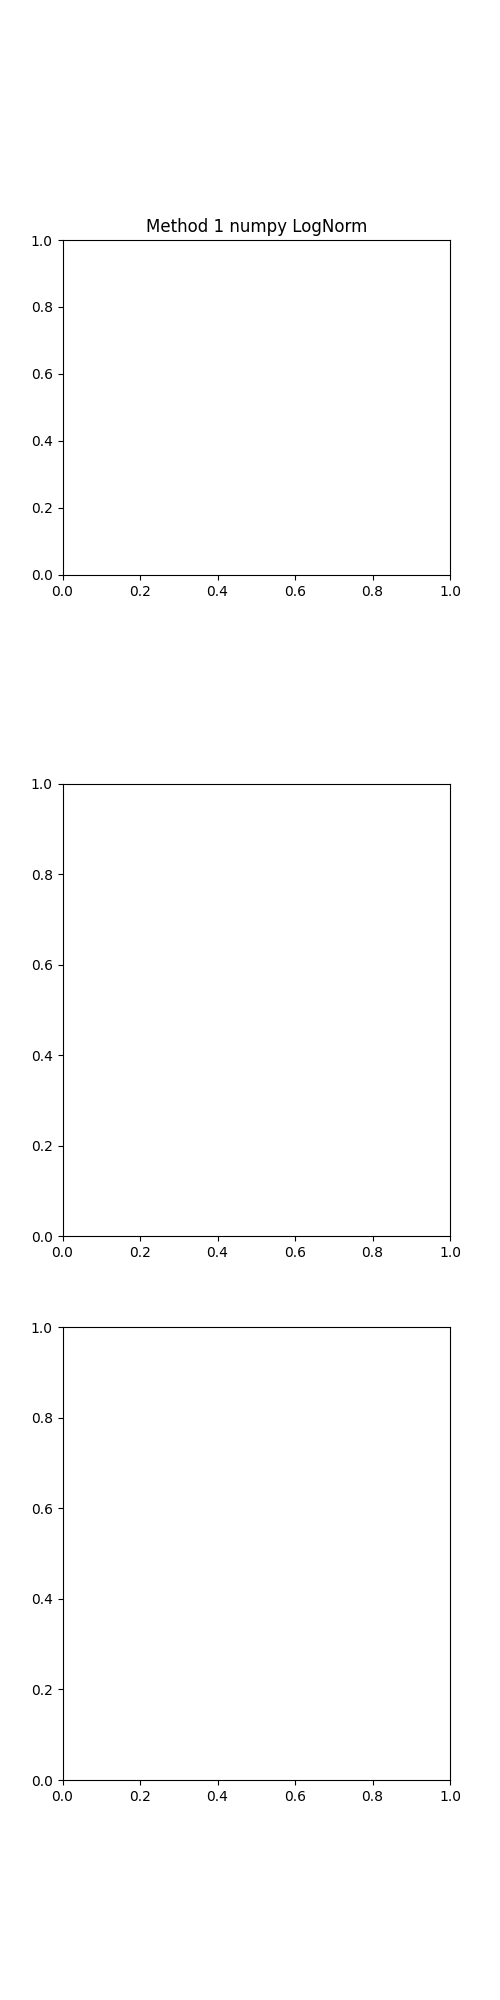

NameError: name 'opt_params' is not defined

In [26]:
fig, ax = plt.subplots(nrows=3, ncols=1,figsize=(5,20))

plt.subplot(4,1,1)
plt.title(r'Method 1 numpy LogNorm')
plt.plot(dataset_sizes,-np.array(opt_params['log_target_true'])+np.array(opt_params['log_target']),color='red')
plt.ylabel('Log target true - Log target MLE')
plt.xlabel('Simulated dataset size')

plt.subplot(4,1,2)
plt.title(r'Method 2 numpy MultivariateNorm')
plt.plot(dataset_sizes,-np.array(opt_params2['log_target_true'])+np.array(opt_params2['log_target']),color='red')
plt.ylabel('Log target true - Log target MLE')
plt.xlabel('Simulated dataset size')

plt.subplot(4,1,3)
plt.title(r'Method 3 scipy LogNorm')
plt.plot(dataset_sizes,-np.array(opt_params3['log_target_true'])+np.array(opt_params3['log_target']),color='red')
plt.ylabel('Log target true - Log target MLE')
plt.xlabel('Simulated dataset size')

plt.subplot(4,1,4)
plt.title(r'Method 4 scipy MultivariateNorm')
plt.plot(dataset_sizes,-np.array(opt_params4['log_target_true'])+np.array(opt_params4['log_target']),color='red')
plt.ylabel('Log target true - Log target MLE')
plt.xlabel('Simulated dataset size')

### Dataset size = 500

In [28]:
opt_params['params'][np.where(dataset_sizes_arr==500)[0][0],:]

NameError: name 'opt_params' is not defined

In [29]:
opt_params2['params'][np.where(dataset_sizes_arr==500)[0][0],:]

NameError: name 'opt_params2' is not defined

In [30]:
opt_params3['params'][np.where(dataset_sizes_arr==500)[0][0],:]

NameError: name 'opt_params3' is not defined

In [31]:
opt_params4['params'][np.where(dataset_sizes_arr==500)[0][0],:]

NameError: name 'opt_params4' is not defined

In [32]:
print(opt_params['log_target'][np.where(dataset_sizes_arr==500)[0][0]])
print(opt_params['log_target_true'][np.where(dataset_sizes_arr==500)[0][0]])

NameError: name 'opt_params' is not defined

In [33]:
print(opt_params2['log_target'][np.where(dataset_sizes_arr==500)[0][0]])
print(opt_params2['log_target_true'][np.where(dataset_sizes_arr==500)[0][0]])

NameError: name 'opt_params2' is not defined

In [34]:
print(opt_params3['log_target'][np.where(dataset_sizes_arr==500)[0][0]])
print(opt_params3['log_target_true'][np.where(dataset_sizes_arr==500)[0][0]])

NameError: name 'opt_params3' is not defined

In [35]:
print(opt_params4['log_target'][np.where(dataset_sizes_arr==500)[0][0]])
print(opt_params4['log_target_true'][np.where(dataset_sizes_arr==500)[0][0]])

NameError: name 'opt_params4' is not defined

## My simulation

In [25]:
# def poisson_estimator(p,s2,x,delta):
#     k = len(x)
#     q_hat = np.ones(k)
#     J = np.random.poisson(delta)
#     for i in range(k):
#         log_q = np.random.normal(loc=np.log(exponential_fd_with_rho(p,x[i])),scale=np.sqrt(s2),size=J)
#         q_hat[i] = np.exp(delta)*(delta**(-J))*np.prod(log_q,axis=0)
#     return q_hat
#     sn = 50000
#     s = np.random.normal(np.log(0.6),0.1,sn)
#     pn = 1000
#     ps = []
#     for i in tqdm(range(pn)):
#         delta = 8
#         c = 0
#         J = np.random.poisson(delta)
#         if J%2 != 0: J += J%2
#         ps.append(np.exp(delta+c)*np.prod((s[np.random.choice(range(sn),J)]-c)/delta))
#     print('Poisson estimator',np.mean(ps))
#     print('Empirical estimator',np.mean(np.exp(s)))

def box_muller(mu,s2):
    # see https://bjlkeng.github.io/posts/sampling-from-a-normal-distribution/
    epsilon = sys.float_info.epsilon
    # Avoid getting u == 0.0
    u1, u2 = 0.0, 0.0
    while u1 < epsilon or u2 < epsilon:
        u1 = random.random()
        u2 = random.random()
        
    x1 = math.sqrt(-2 * math.log(u1)) * math.cos(2 * math.pi * u2)
    x2 = math.sqrt(-2 * math.log(u1)) * math.sin(2 * math.pi * u2)
    return x1*np.sqrt(s2)+mu

def sample_from_lognormal(p,s2,x,_seed:int=None):
    k = len(x)
    q1 = np.array([box_muller(np.log(exponential_fd_with_rho([alpha,beta],x[i])),s2) for i in range(k)])
    return np.exp(q1)

In [147]:
n1 = 20
n2 = 60
n3 = 20

selected_n = n1 + n2 + n3
# Decide on parameters
alpha = 0.6 
beta = 0.1
# Define noise
mysigma2 = 0.001
p0_lt = [alpha,beta]
myseed = None
n_pertubations = 1000


# Generate rho
mysimrho = np.linspace(0.01,40,selected_n)
#np.concatenate([np.linspace(0.01,5,n1),np.linspace(5,15,n2),np.linspace(15,40,n3)])

# Simulate q 
mysimq_true = exponential_fd_with_rho([alpha,beta,mysigma2],mysimrho)

# Get mean and standard deviation
myexp_mean = mysimq_true / np.sqrt(1 + mysigma2)
mymean = np.log(myexp_mean)
myvar = np.log(1+mysigma2)
mystdev = np.sqrt(myvar)

simparams = np.zeros((n_pertubations,4,2))
simlogtarget = np.zeros((n_pertubations,4))
simtruelogtarget = np.zeros((n_pertubations,4))

for i in tqdm(range(n_pertubations)):

    # Simulate q in multiple ways
    # Method 1
#     np.random.seed(myseed)
#     mysimq1 = np.array([np.random.lognormal(mean = mymean[i],sigma = mystdev) for i in range(selected_n)])
    # Method 2
#     np.random.seed(myseed)
#     mysimlogq2 = np.random.multivariate_normal(mean = mymean,cov = np.eye(selected_n)*myvar)
#     mysimq2 = np.exp(mysimlogq2)
    # Method 3
    np.random.seed(myseed)
    mysimq3 = np.array([ss.lognorm.rvs(s = mystdev,loc = 0,scale = myexp_mean[i]) for i in range(selected_n)])
    # Method 4
#     np.random.seed(myseed)
#     mysimlogq4 = ss.multivariate_normal.rvs(mean = mymean,cov = np.eye(selected_n)*myvar)
#     mysimq4 = np.exp(mysimlogq4)
    # Method 5
    # np.random.seed(myseed)
    # mysimq5 = sample_from_lognormal([alpha,beta],mysigma2,mysimrho)
    # Method 6
    # np.random.seed(myseed)
    # mysimq6 = poisson_estimator([alpha,beta],sigma2,mysimrho,1)
#     print('Simulation done')

#     mylog_target_ls = so.minimize(neg_log_likelihood, p0_lt, args=(mysigma2,mysimq1,mysimrho),method='SLSQP')
#     mylog_target_ls_params = mylog_target_ls.x
#     mylog_target = -neg_log_likelihood(mylog_target_ls_params,mysigma2,mysimq1,mysimrho)

#     simparams[i,0,:] = np.array(mylog_target_ls_params) 
#     simlogtarget[i,0] = mylog_target
#     simtruelogtarget[i,0] = -neg_log_likelihood([alpha,beta],mysigma2,mysimq1,mysimrho)
#     print(f"Method 1: Parameters = {mylog_target_ls_params}")
#     print(f'Inferred log target = {mylog_target} vs true log target = {-neg_log_likelihood([alpha,beta],mysigma2,mysimq1,mysimrho)}')

#     mylog_target_ls2 = so.minimize(neg_log_likelihood, p0_lt, args=(mysigma2,mysimq2,mysimrho),method='SLSQP')
#     mylog_target_ls2_params = mylog_target_ls2.x
#     mylog_target2 = -neg_log_likelihood(mylog_target_ls2_params,mysigma2,mysimq2,mysimrho)
    
#     simparams[i,1,:] = np.array(mylog_target_ls2_params) 
#     simlogtarget[i,1] = mylog_target2
#     simtruelogtarget[i,1] = -neg_log_likelihood([alpha,beta],mysigma2,mysimq2,mysimrho)
# #     print(f"Method 2: Parameters = {mylog_target_ls2_params}")
#     print(f'Inferred log target = {mylog_target2} vs true log target = {-neg_log_likelihood([alpha,beta],mysigma2,mysimq2,mysimrho)}')

    mylog_target_ls3 = so.minimize(neg_log_likelihood, p0_lt, args=(mysigma2,mysimq3,mysimrho),method='SLSQP')
    mylog_target_ls3_params = mylog_target_ls3.x
    mylog_target3 = -neg_log_likelihood(mylog_target_ls3_params,mysigma2,mysimq3,mysimrho)
    
    simparams[i,2,:] = np.array(mylog_target_ls3_params) 
    simlogtarget[i,2] = mylog_target3
    simtruelogtarget[i,2] = -neg_log_likelihood([alpha,beta],mysigma2,mysimq3,mysimrho)
#     print(f"Method 3: Parameters = {mylog_target_ls3_params}")
#     print(f'Inferred log target = {mylog_target3} vs true log target = {-neg_log_likelihood([alpha,beta],mysigma2,mysimq3,mysimrho)}')

#     mylog_target_ls4 = so.minimize(neg_log_likelihood, p0_lt, args=(mysigma2,mysimq4,mysimrho),method='SLSQP')
#     mylog_target_ls4_params = mylog_target_ls4.x
#     mylog_target4 = -neg_log_likelihood(mylog_target_ls4_params,mysigma2,mysimq4,mysimrho)
    
#     simparams[i,3,:] = np.array(mylog_target_ls4_params) 
#     simlogtarget[i,3] = mylog_target4
#     simtruelogtarget[i,3] = -neg_log_likelihood([alpha,beta],mysigma2,mysimq4,mysimrho)
#     print(f"Method 4: Parameters = {mylog_target_ls4_params}")
#     print(f'Inferred log target = {mylog_target4} vs true log target = {-neg_log_likelihood([alpha,beta],mysigma2,mysimq4,mysimrho)}')

    # mylog_target_ls5 = so.minimize(neg_log_likelihood, p0_lt, args=(mysigma2,mysimq5,mysimrho),method='SLSQP')
    # mylog_target_ls5_params = mylog_target_ls5.x
    # mylog_target5 = -neg_log_likelihood(mylog_target_ls5_params,mysigma2,mysimq5,mysimrho)
    # print(f"Method 5: Parameters = {mylog_target_ls5_params}")
    # print(f'Inferred log target = {mylog_target5} vs true log target = {-neg_log_likelihood([alpha,beta],mysigma2,mysimq5,mysimrho)}')

    # mylog_target_ls6 = so.minimize(neg_log_likelihood, p0_lt, args=(mysigma2,mysimq6,mysimrho),method='SLSQP')
    # mylog_target_ls6_params = mylog_target_ls6.x
    # mylog_target6 = -neg_log_likelihood(mylog_target_ls6_params,mysigma2,mysimq6,mysimrho)
    # print(f"Method 6: Parameters = {mylog_target_ls6_params}")
    # print(f'Inferred log target = {mylog_target6} vs true log target = {-neg_log_likelihood([alpha,beta],mysigma2,mysimq6,mysimrho)}')

#     mylog_target_ls7 = so.minimize(neg_log_likelihood, p0_lt, args=(mysigma2,mysimq7,mysimrho),method='SLSQP')
#     mylog_target_ls7_params = mylog_target_ls7.x
#     mylog_target7 = -neg_log_likelihood(mylog_target_ls7_params,mysigma2,mysimq7,mysimrho)
#     print(f"Method 7: Parameters = {mylog_target_ls7_params}")
#     print(f'Inferred log target = {mylog_target7} vs true log target = {-neg_log_likelihood([alpha,beta],mysigma2,mysimq7,mysimrho)}')

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/Yannis/.pyenv/versions/3.7.5/envs/ptfm/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Yannis/.pyenv/versions/3.7.5/envs/ptfm/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in log
/Users/Yannis/.pyenv/versions/3.7.5/envs/ptfm/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Yannis/.pyenv/versions/3.7.5/envs/ptfm/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in log
100%|██████████| 1000/1000 [00:49<00:00, 20.20it/s]


<IPython.core.display.Javascript object>


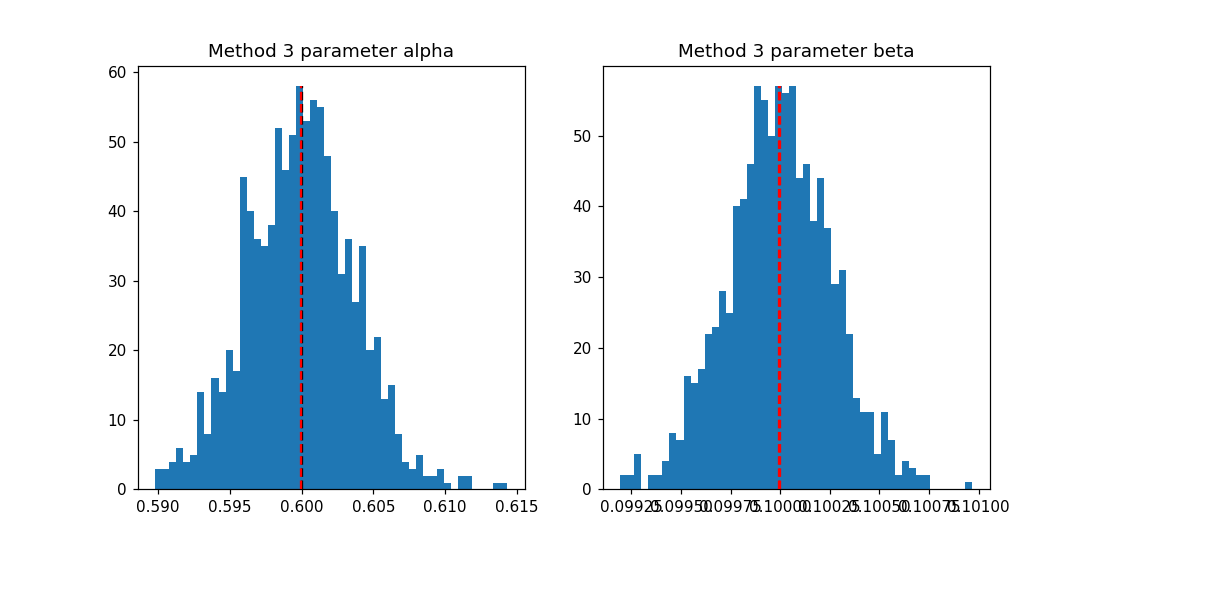

In [156]:
nbins = 50
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10,5))

plt.subplot(1,2,1)
plt.title('Method 3 parameter alpha')
freq3alpha = plt.hist(simparams[:,2,0],bins = nbins,zorder=1)
plt.vlines(np.mean(simparams[:,2,0]),np.min(freq3alpha[0]),np.max(freq3alpha[0]),color='red',linestyle='dashed',zorder=3)
plt.vlines(alpha,np.min(freq3alpha[0]),np.max(freq3alpha[0]),color='black',linestyle='dashed',zorder=2)

plt.subplot(1,2,2)
plt.title('Method 3 parameter beta')
freq3beta = plt.hist(simparams[:,2,1],bins = nbins,zorder=1)
plt.vlines(np.mean(simparams[:,2,1]),np.min(freq3beta[0]),np.max(freq3beta[0]),color='red',linestyle='dashed',zorder=3)
plt.vlines(beta,np.min(freq3beta[0]),np.max(freq3beta[0]),color='red',linestyle='dashed',zorder=2)

<IPython.core.display.Javascript object>


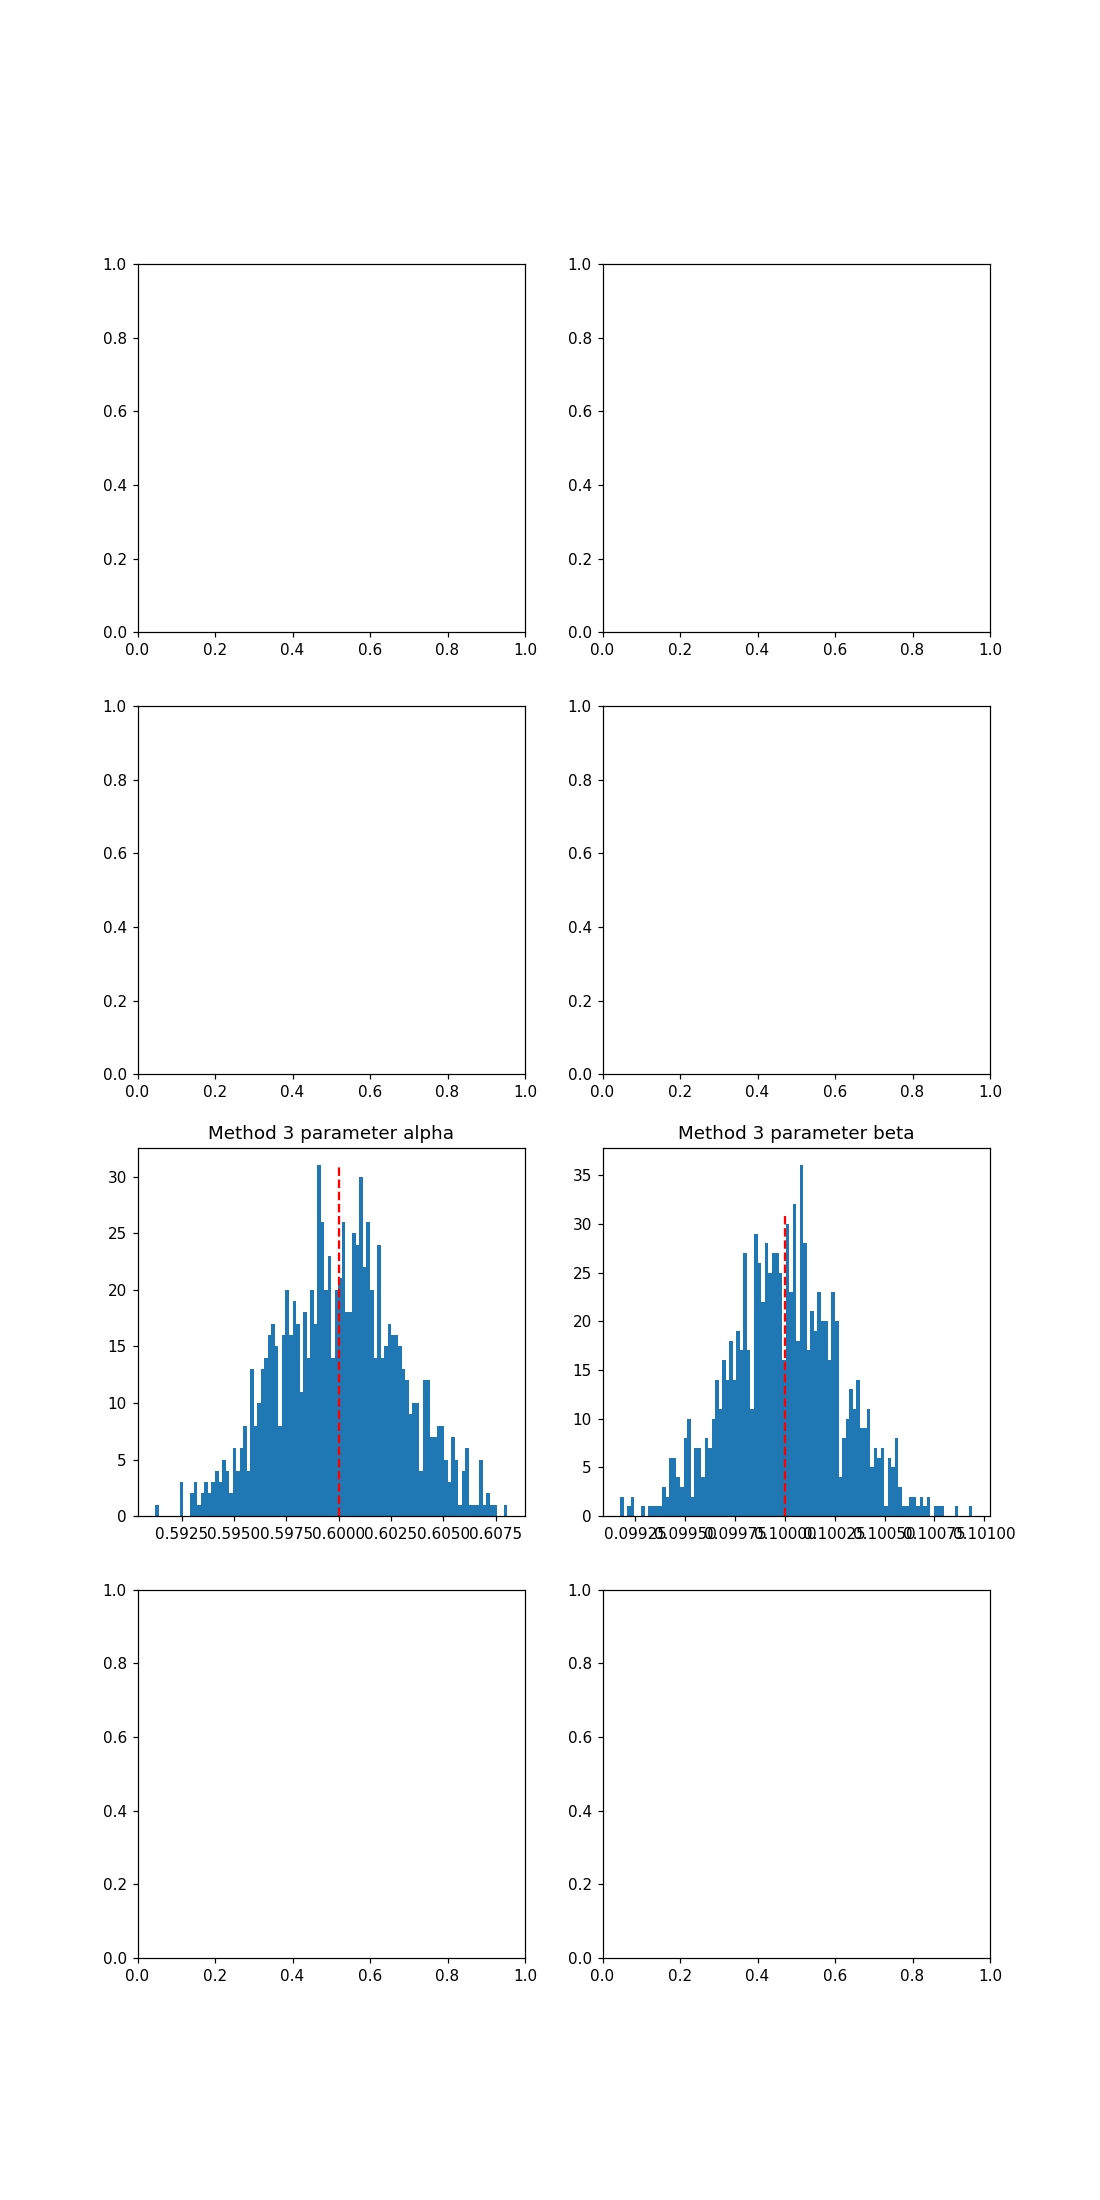

In [138]:
# nbins = 100
# fig, ax = plt.subplots(nrows=4, ncols=2,figsize=(10,20))

# plt.subplot(4,2,1)
# plt.title('Method 1 parameter alpha')
# freq1alpha = plt.hist(simparams[:,0,0],bins = nbins)
# plt.vlines(alpha,np.min(freq1alpha[0]),np.max(freq1alpha[0]),color='red',linestyle='dashed')

# plt.subplot(4,2,2)
# plt.title('Method 1 parameter beta')
# freq1beta = plt.hist(simparams[:,0,1],bins = nbins)
# plt.vlines(beta,np.min(freq1beta[0]),np.max(freq1beta[0]),color='red',linestyle='dashed')

# plt.subplot(4,2,3)
# plt.title('Method 2 parameter alpha')
# freq2alpha = plt.hist(simparams[:,1,0],bins = nbins)
# plt.vlines(alpha,np.min(freq2alpha[0]),np.max(freq2alpha[0]),color='red',linestyle='dashed')

# plt.subplot(4,2,4)
# plt.title('Method 2 parameter beta')
# freq2beta = plt.hist(simparams[:,1,1],bins = nbins)
# plt.vlines(beta,np.min(freq2beta[0]),np.max(freq2beta[0]),color='red',linestyle='dashed')

# plt.subplot(4,2,5)
# plt.title('Method 3 parameter alpha')
# freq3alpha = plt.hist(simparams[:,2,0],bins = nbins)
# plt.vlines(alpha,np.min(freq3alpha[0]),np.max(freq3alpha[0]),color='red',linestyle='dashed')

# plt.subplot(4,2,6)
# plt.title('Method 3 parameter beta')
# freq3beta = plt.hist(simparams[:,2,1],bins = nbins)
# plt.vlines(beta,np.min(freq3beta[0]),np.max(freq3beta[0]),color='red',linestyle='dashed')

# plt.subplot(4,2,7)
# plt.title('Method 4 parameter alpha')
# freq3alpha = plt.hist(simparams[:,3,0],bins = nbins)
# plt.vlines(alpha,np.min(freq3alpha[0]),np.max(freq3alpha[0]),color='red',linestyle='dashed')

# plt.subplot(4,2,8)
# plt.title('Method 4 parameter beta')
# freq4alpha = plt.hist(simparams[:,3,1],bins = nbins)
# plt.vlines(beta,np.min(freq4alpha[0]),np.max(freq4alpha[0]),color='red',linestyle='dashed')

<IPython.core.display.Javascript object>


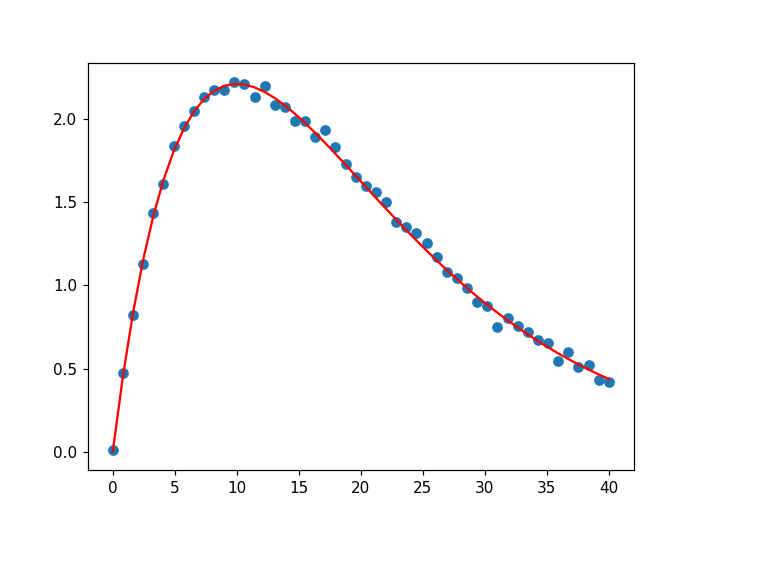

In [27]:
%matplotlib notebook

plt.scatter(mysimrho,mysimq1)
# plt.scatter(mysimrho,mysimq2)
# plt.scatter(mysimrho,mysimq6)
# plt.scatter(mysimrho,mysimq4)
plt.plot(mysimrho,mysimq_true,color='red')
plt.show()

In [31]:
exp_mean = mysimq_true / np.sqrt(1 + mysigma2)
stdev = np.sqrt(np.log(1+mysigma2))
q_sim = np.array([ss.lognorm.rvs(scale = (exp_mean[i]), s = stdev) for i in range(len(mysimq_true))]

<IPython.core.display.Javascript object>


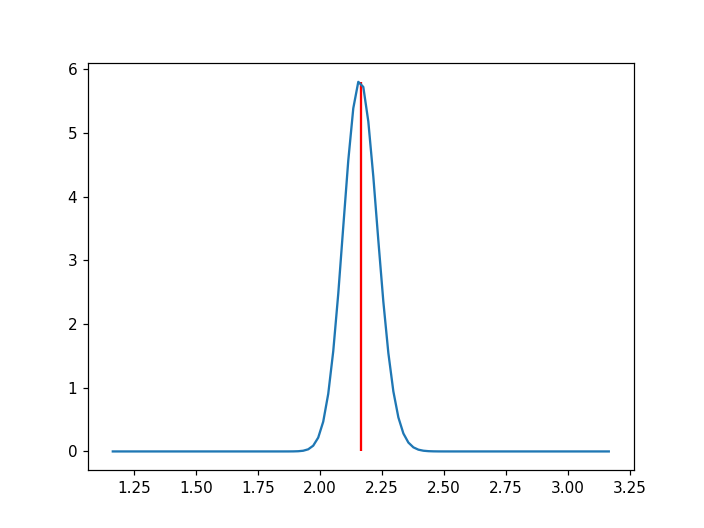

In [45]:
i = 10
qrange = np.linspace(mysimq_true[i]-1,mysimq_true[i]+1,100)
q_simi = ss.lognorm.pdf(qrange, scale = (exp_mean[i]), s = stdev)
%matplotlib notebook
plt.plot(qrange,q_simi)
plt.vlines(mysimq_true[i],0,np.max(q_simi),color='red')

<IPython.core.display.Javascript object>


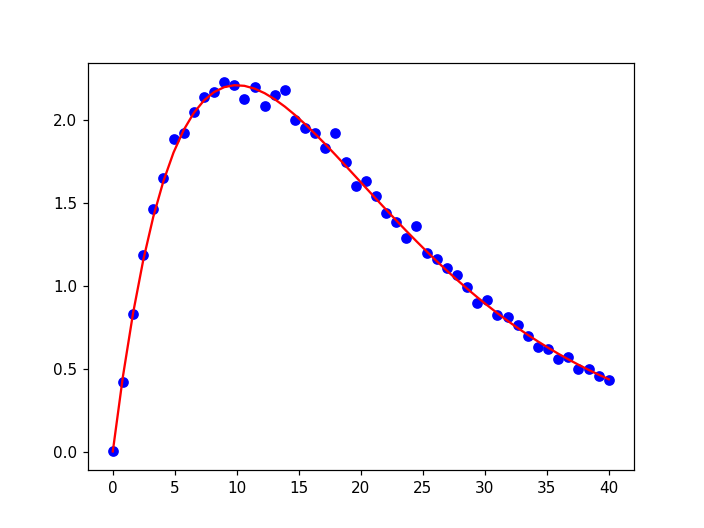

In [32]:
%matplotlib notebook
plt.scatter(mysimrho,q_sim,color='blue')
plt.plot(mysimrho,mysimq_true,color='red')
plt.show()

### Jacobian transformation of likelihood

In [128]:
p_inferred = [0.6008728148609189,0.10004677701653436,sigma2]
p_random = [0.60003951,0.10000594,sigma2]

In [138]:
exponential_fd_log_likelihood_norm(p_true,q)

1654.986005430203

In [139]:
exponential_fd_log_likelihood_norm(p_inferred,q)

1656.263542996833

In [140]:
exponential_fd_log_likelihood_norm(p_random,q)

1655.119592347254

### True unnormalised parameter posterior (based on target)

In [16]:
load_data = False
filename_extension = '_test'
#'','_concentrated'

In [317]:
# # Define grid quantities
# amin = 0.55#alpha_lower#0.18
# #alpha/3, 0.45
# amax = 0.65#alpha_upper#0.22
# #alpha*2 , 0.75
# bmin = 0.05#beta_lower#0.017
# #beta/3, 0.12
# bmax = 0.15#beta_upper#0.022
# #beta*2 ,0.08
# n_steps_a = 100# 22
# n_steps_b = 100

# a = np.linspace(amin,amax,n_steps_a)
# b = np.linspace(bmin,bmax,n_steps_b)
# # Create mesh
# B,A = np.meshgrid(b,a)
# # Compute unnormalised log posterior
# log_unnormalised_posterior_value = np.zeros((n_steps_a,n_steps_b))
# log_prior_value = np.zeros((n_steps_a,n_steps_b))
# log_likelihood_value = np.zeros((n_steps_a,n_steps_b))
# for i in tqdm(range(n_steps_a)):
#     for j in range(n_steps_b):
#         log_unnormalised_posterior_value[i,j] = exponential_fd_log_target([a[i],b[j],sigma2],q)
#         log_prior_value[i,j] = exponential_fd_log_prior([a[i],b[j],sigma2])
#         log_likelihood_value[i,j] = exponential_fd_log_likelihood([a[i],b[j],sigma2],q)
        
# #         print([a[i],b[j]])
# #         print(log_prior_value[i,j])

In [318]:
# _vmin = np.min(log_unnormalised_posterior_value[np.isfinite(log_unnormalised_posterior_value)])
# _vmax = np.max(log_unnormalised_posterior_value[np.isfinite(log_unnormalised_posterior_value)])
# levels = np.linspace(_vmin,_vmax,20)
# plt.ion()
# plt.figure(figsize=(10,8))
# # Create a contour
# print(f'MAP = {A.flatten()[np.argmax(log_unnormalised_posterior_value)]}, beta={B.flatten()[np.argmax(log_unnormalised_posterior_value)]}')
# B,A = np.meshgrid(b,a)
# im = plt.contourf(A, B, log_unnormalised_posterior_value,levels)
# plt.scatter(A.flatten()[np.argmax(log_unnormalised_posterior_value)],B.flatten()[np.argmax(log_unnormalised_posterior_value)],label='MAP',marker='x',s=200,color='blue',zorder=10)
# plt.scatter(alpha,beta,label='OLS',marker='x',s=100,color='black',zorder=9)
# plt.xlim([amin, amax])
# plt.ylim([bmin, bmax])
# plt.xlabel(r'$\alpha$',fontsize=16)
# plt.ylabel(r'$\beta$',fontsize=16)
# plt.title(r'Log unnormalised posterior',fontsize=18)
# plt.colorbar(im)
# plt.legend()

In [319]:
# if not load_data:
#     # Define grid quantities
#     amin = alpha_lower#0.18
#     #alpha/3, 0.45
#     amax = alpha_upper#0.22
#     #alpha*2 , 0.75
#     bmin = beta_lower#0.017
#     #beta/3, 0.12
#     bmax = beta_upper#0.022
#     #beta*2 ,0.08
#     n_steps_a = 100# 22
#     n_steps_b = 100
    
#     a = np.linspace(amin,amax,n_steps_a)
#     b = np.linspace(bmin,bmax,n_steps_b)
#     # Create mesh
#     B,A = np.meshgrid(b,a)
#     # Compute unnormalised log posterior
#     # log_unnormalised_posterior_value = log_exponential_fd_target_vector(A,B)
#     log_unnormalised_posterior_value = np.zeros((n_steps_a,n_steps_b))
#     for i in tqdm(range(n_steps_a)):
#         for j in range(n_steps_b):
#             log_unnormalised_posterior_value[i,j] = exponential_fd_log_target([a[i],b[j],sigma2],q)
#     Q_hat = copy.deepcopy(log_unnormalised_posterior_value)

#     # Export true posterior
#     np.savetxt(base_url+f'true_parameter_posterior{filename_extension}_sigma2_{str(sigma2).replace(".",",")}.txt',Q_hat)
#     np.savetxt(base_url+'rho.txt',rho)
#     np.savetxt(base_url+'q.txt',q)

#     true_posterior_metadata = {}
#     true_posterior_metadata['n_steps_a'] = n_steps_a
#     true_posterior_metadata['n_steps_b'] = n_steps_b
#     true_posterior_metadata['amin'] = amin
#     true_posterior_metadata['true_alpha'] = alpha
#     true_posterior_metadata['true_beta'] = beta
#     true_posterior_metadata['amax'] = amax
#     true_posterior_metadata['bmin'] = bmin
#     true_posterior_metadata['bmax'] = bmax
#     true_posterior_metadata['beta_prior_alpha_param'] = {'a':beta_prior_a_alpha_param,'b':beta_prior_b_alpha_param}
#     true_posterior_metadata['beta_prior_beta_param'] = {'a':beta_prior_a_beta_param,'b':beta_prior_b_beta_param}
    
    
#     # print(json.dumps(metadata, indent=2))

#     with open(base_url+f'true_parameter_posterior{filename_extension}_sigma2_{str(sigma2).replace(".",",")}_metadata.json', 'w') as outfile:
#         json.dump(true_posterior_metadata, outfile)
    
# else:
#     # LOAD DATA
    
#     # Load true posterior
#     Q_hat = np.loadtxt(base_url+f'true_parameter_posterior{filename_extension}_sigma2_{str(sigma2).replace(".",",")}.txt') 

#     # Load true posterior metadata
#     with open(base_url+f'true_parameter_posterior{filename_extension}_sigma2_{str(sigma2).replace(".",",")}_metadata.json') as json_file:
#         true_posterior_metadata = json.load(json_file)

#     # Define parameter grid 
#     a = np.linspace(true_posterior_metadata['amin'],true_posterior_metadata['amax'],true_posterior_metadata['n_steps_a'])
#     b = np.linspace(true_posterior_metadata['bmin'],true_posterior_metadata['bmax'],true_posterior_metadata['n_steps_b'])
#     # Create mesh
#     B,A = np.meshgrid(b,a)

#     # Store grid quantities
#     amin = true_posterior_metadata['amin']
#     amax = true_posterior_metadata['amax']
#     bmin = true_posterior_metadata['bmin']
#     bmax = true_posterior_metadata['bmax']
#     n_steps_a = true_posterior_metadata['n_steps_a']
#     n_steps_b = true_posterior_metadata['n_steps_b']
#     alpha = true_posterior_metadata['true_alpha']
#     beta = true_posterior_metadata['true_beta']
#     beta_prior_a_alpha_param = true_posterior_metadata['beta_prior_alpha_param']['a'] 
#     beta_prior_b_alpha_param = true_posterior_metadata['beta_prior_alpha_param']['b'] 
#     beta_prior_a_beta_param = true_posterior_metadata['beta_prior_beta_param']['a'] 
#     beta_prior_b_beta_param = true_posterior_metadata['beta_prior_beta_param']['b'] 

#     # Reshape
#     Q_hat = np.array(Q_hat).reshape((n_steps_a,n_steps_b))

### Plot unnormalised log posterior surface

In [320]:
# _vmin = 0#np.min(Q_hat[np.isfinite(Q_hat)])
# _vmax = np.max(Q_hat[np.isfinite(Q_hat)])

# plt.ion()
# plt.figure(figsize=(10,8))
# # Create a contour
# print(f'alpha_map = {A.flatten()[np.argmax(Q_hat)]}, beta={B.flatten()[np.argmax(Q_hat)]}')
# B,A = np.meshgrid(b,a)
# im = plt.contourf(A, B, Q_hat,600,vmin=_vmin,vmax=_vmax)
# plt.scatter(A.flatten()[np.argmax(Q_hat)],B.flatten()[np.argmax(Q_hat)],label='MAP',marker='x',s=200,color='blue',zorder=10)
# plt.scatter(alpha,beta,label='OLS',marker='x',s=100,color='black',zorder=9)
# plt.xlim([true_posterior_metadata['amin'], true_posterior_metadata['amax']])
# plt.ylim([true_posterior_metadata['bmin'], true_posterior_metadata['bmax']])
# plt.xlabel(r'$\alpha$',fontsize=16)
# plt.ylabel(r'$\beta$',fontsize=16)
# plt.title(r'Log unnormalised posterior',fontsize=18)
# plt.colorbar(im)
# plt.legend()

In [321]:
def grw_mcmc(log_target, kernel, _p0, _y, _K, _N, _beta,seed=None,print_stat:bool=False):
    """ Gaussian Random Walk Metropolis Hastings MCMC method for sampling from pdf defined by log_prior and log_likelihood.
    Inputs:
        log_likelihood - log-likelihood function
        _p0 - initial sample
        _y - observed data
        _sigma2 - prior variance
        _N - number of samples
        _beta - step-size parameter
    Returns:
        _theta - samples from target distribution
        acc/n_iters - the proportion of accepted samples"""
        
    np.random.seed(seed)
    
    _theta = []
    _theta_proposed = []
    acc = 0
    p_prev = copy.deepcopy(_p0)
    
    for i in tqdm(range(_N)):
        
        # Evaluate log 
        lt_prev = log_target(p_prev, _y)
#         lp_prev = exponential_fd_log_prior(p_prev)
#         ll_prev = exponential_fd_log_likelihood(p_prev,_y)
    
    
        # Propose new sample using GRW proposal
        p_new = kernel(p_prev,_beta,_K)
        
        lt_new = log_target(p_new, _y)    
#         lp_new = exponential_fd_log_prior(p_new)
#         ll_new = exponential_fd_log_likelihood(p_new,_y)
        
#         print('p_prev',p_prev,'lt_prev',lt_prev)
#         print('p_new',p_new,'lt_new',lt_new)
#         print('lp_prev',lp_prev)
#         print('ll_prev',ll_prev)
#         print('lp_new',lp_new)
#         print('ll_new',ll_new)
#         print(f'Acceptance rate {int(100*acc / _N)}%')
#         sys.exit(1)
        
        
        # Printing proposals every 0.1*Nth iteration 
        if print_stat and i in [int(j/10*_N) for j in range(1,11)]:
            print('p_prev',p_prev,'lt_prev',lt_prev)
            print('p_new',p_new,'lt_new',lt_new)
            print(f'Acceptance rate {int(100*acc / _N)}%')

        # TODO: Calculate GRW acceptance probability
        log_acc = lt_new - lt_prev
        log_u = np.log(np.random.random())

        # Accept/Reject
        # Compare log_alpha and log_u to accept/reject sample
        if min(np.exp(log_acc),1) >= np.exp(log_u):
            if print_stat and i in [int(j/10*_N) for j in range(1,11)]:
                print('Accepted!')
                print('p_new =',p_prev)
            acc += 1
            _theta.append(p_new)
            p_prev = p_new
            _theta_proposed.append(p_new)
        else:
            _theta.append(p_prev)
            _theta_proposed.append(p_new)

    return np.array(_theta), np.array(_theta_proposed), acc / _N

In [325]:
load_data = True
algorithm = 'grwmh'
data_id = 'exponential_fd_simulation_smaller_more_data'

In [326]:
if load_data:
    output_base_url = '../data/output/inference_data'
    grw_mcmc_parameters = np.loadtxt((output_base_url+'/'+data_id+'/'+algorithm+'/'+filename+'/'+'theta.txt'))
    grw_mcmc_parameters_proposed = np.loadtxt((output_base_url+'/'+data_id+'/'+algorithm+'/'+filename+'/'+'theta_proposed.txt'))
    with open((output_base_url+'/'+data_id+'/'+algorithm+'/'+filename+'/'+'metadata.json')) as json_file:
        grw_posterior_metadata = json.load(json_file)
    grw_mcmc_acceptance = float(grw_posterior_metadata['results']['vanilla_mcmc']['acceptance_rate'])/100
else:
    grw_mcmc_parameters,grw_mcmc_parameters_proposed,grw_mcmc_acceptance = grw_mcmc(exponential_fd_log_target,
                                                            gaussian_transition_kernel,
                                                            np.array(parameters_init),
                                                            q,
                                                            proposal_covariance,
                                                            N,
                                                            beta_step,
                                                            2021,
                                                            False)
print('Metropolis Hastings Gaussian Random Walk MCMC')
print(f'Acceptance rate {int(grw_mcmc_acceptance*100)}%')

Metropolis Hastings Gaussian Random Walk MCMC
Acceptance rate 47%


### Try plotting some proposals

In [327]:
alpha_prev = alpha
beta_prev = beta

alpha_new = 0.6008376937259922
beta_new = 0.10004581761772027

q_prev = exponential_fd([alpha_prev,beta_prev])
q_new = exponential_fd([alpha_new,beta_new])

print(f'p_prev = {[alpha_prev,beta_prev,sigma2]}')
lt_prev = exponential_fd_log_target([alpha_prev,beta_prev,sigma2],q)
print(f'lt_prev = {exponential_fd_log_target([alpha_prev,beta_prev,sigma2],q)}')
print(f'll_prev = {exponential_fd_log_likelihood([alpha_prev,beta_prev,sigma2],q)}')
print(f'lp_prev = {exponential_fd_log_prior([alpha_prev,beta_prev,sigma2])}')
print("\n")
print(f'p_new = {[alpha_new,beta_new,sigma2]}')
lt_new = exponential_fd_log_target([alpha_new,beta_new,sigma2],q)
print(f'lt_new = {exponential_fd_log_target([alpha_new,beta_new,sigma2],q)}')
print(f'll_new = {exponential_fd_log_likelihood([alpha_new,beta_new,sigma2],q)}')
print(f'lp_new = {exponential_fd_log_prior([alpha_new,beta_new,sigma2])}')
print("\n")
print('From prev to new probability', np.exp(lt_prev-lt_new))
print('From new to prev probability', np.exp(lt_new-lt_prev))

p_prev = [0.6, 0.1, 0.0001]
lt_prev = 1657.1487755806697
ll_prev = 1654.9860054302035
lp_prev = 2.162770150466211


p_new = [0.6008376937259922, 0.10004581761772027, 0.0001]
lt_new = 1658.4235164394938
ll_new = 1656.262605594945
lp_new = 2.1609108445489826


From prev to new probability 0.2795033896743832
From new to prev probability 3.5777741413618753


In [120]:
# plt.figure(figsize=(10,10))
# plt.scatter(rho,q,color='black',alpha=0.1,label='true')
# plt.plot(rho,q_prev,color='red',label='previous')
# plt.plot(rho,q_new,color='blue',label='new')
# plt.xlabel(r'$\rho$')
# plt.ylabel(r'$q$')
# plt.legend()

In [121]:
# _vmin = 0#np.min(Q_hat[np.isfinite(Q_hat)])
# _vmax = np.max(Q_hat[np.isfinite(Q_hat)])
# _n = 40

# levels = np.linspace(_vmin, _vmax, _n)
# plt.ion()
# plt.figure(figsize=(10,8))
# # Create a contour
# print(f'alpha_map = {A.flatten()[np.argmax(Q_hat)]}, beta={B.flatten()[np.argmax(Q_hat)]}')
# B,A = np.meshgrid(b,a)
# im = plt.contourf(A, B, Q_hat, levels=levels)
# plt.scatter(A.flatten()[np.argmax(Q_hat)],B.flatten()[np.argmax(Q_hat)],label='MAP',marker='x',s=200,color='blue',zorder=10)
# plt.scatter(alpha,beta,label='OLS',marker='x',s=100,color='black',zorder=9)
# plt.scatter(alpha_prev,beta_prev,label='p_prev',marker='x',s=100,color='red',zorder=11)
# # plt.scatter(alpha_new,beta_new,label='p_new',marker='x',s=100,color='purple',zorder=8)
# plt.xlim([true_posterior_metadata['amin'], true_posterior_metadata['amax']])
# plt.ylim([true_posterior_metadata['bmin'], true_posterior_metadata['bmax']])
# plt.xlabel(r'$\alpha$',fontsize=16)
# plt.ylabel(r'$\beta$',fontsize=16)
# plt.title(r'Log unnormalised posterior',fontsize=18)
# plt.colorbar(im)
# plt.legend()

### Compute Gelman Rubin convergence diagnostic

In [122]:
# grw_mcmc_gelman_rubin_statistic = gelman_rubin_statistic(grw_mcmc_parameters[1:,])

### Figure out proposal variances for beta step

In [162]:
current_k_diag = [0.0125,0.0000825]#[0.00125, 0.000125]
current_beta_step = 0.03
desired_beta_step = 0.01

In [163]:
avar = current_beta_step**2*current_k_diag[0]

In [164]:
expected_avar = avar/(desired_beta_step**2)

In [146]:
bvar = current_beta_step**2*current_k_diag[1]

In [147]:
expected_bvar = bvar/(desired_beta_step**2)

In [148]:
expected_bvar

1.2499999999999999e-06

In [150]:
0.00000125

1.25e-06

### Inspect samples 

In [204]:
burnin = 18000

<IPython.core.display.Javascript object>


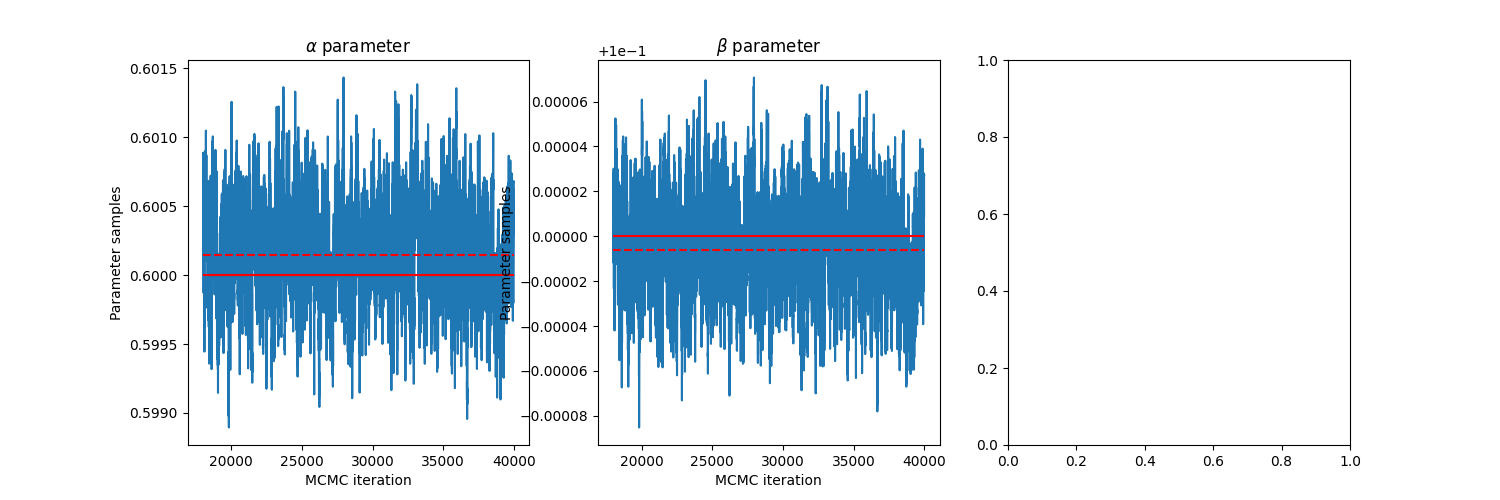

mean = 0.6001761940100435
mean = 0.09999541355016614


In [215]:
%matplotlib notebook
fig, ax = plt.subplots(nrows=1, ncols=num_params,figsize=(15,5))
for i in range(1,num_params):
    print('mean =',np.mean(grw_mcmc_parameters[burnin:,i-1]))
    plt.subplot(1,num_params,i)
    plt.title(f'{param_names[i-1]} parameter')
    plt.plot(range(burnin+1,N+1),grw_mcmc_parameters[burnin:,i-1],label='Sampled chains',zorder=1)
    plt.hlines(np.mean(grw_mcmc_parameters[burnin::100,i-1]),burnin+1,N+1,color='red',linestyle='dashed',label='Mean',zorder=2)
    plt.hlines(true_params[i-1],burnin+1,N+1,color='red',label='True',zorder=3)
    plt.ylabel('Parameter samples')
    plt.xlabel('MCMC iteration')
    plt.ioff()
if export_data: plt.savefig(base_url+method+'/figures/'+filename+'_mixing.png')


<IPython.core.display.Javascript object>


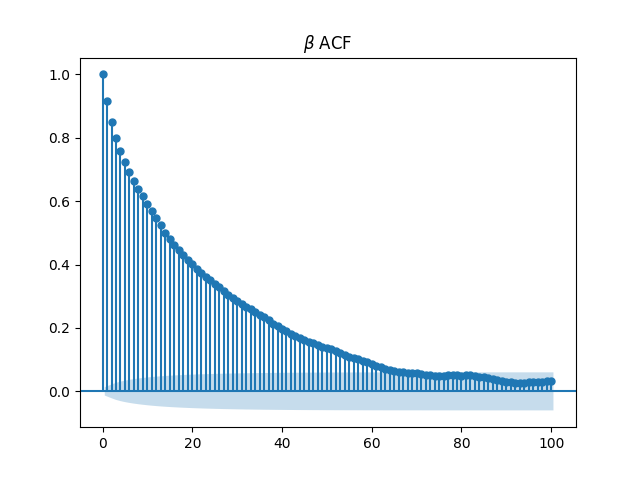

In [211]:
sm.graphics.tsa.plot_acf(grw_mcmc_parameters[burnin:,1], lags=100,title=r'$\beta$ ACF')

ValueError: could not broadcast input array from shape (10,) into shape (101,)

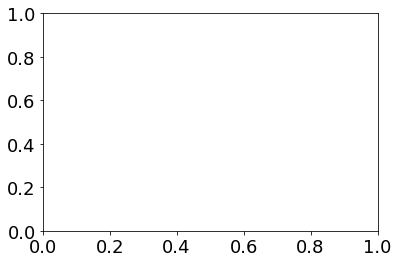

In [32]:
# Plot autocorrelation function
sm.graphics.tsa.plot_acf(grw_mcmc_parameters[burnin:,0], lags=100,title=r'$\alpha$ ACF')
if export_data: plt.savefig(base_url+method+'/figures/'+filename+'_alpha_acf.png')
sm.graphics.tsa.plot_acf(grw_mcmc_parameters[burnin:,1], lags=100,title=r'$\beta$ ACF')
if export_data: plt.savefig(base_url+method+'/figures/'+filename+'_beta_acf.png')
plt.show()

alpha_map = 0.6041812044347173, beta=0.10015400471316754


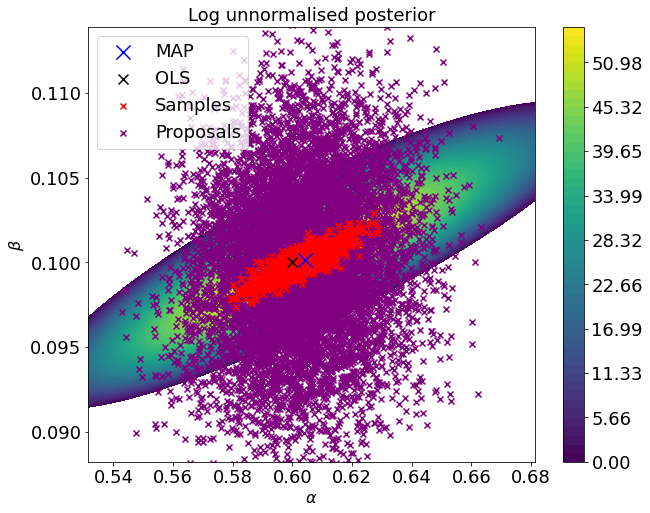

In [220]:
_vmin = 0#np.min(Q_hat[np.isfinite(Q_hat)])
_vmax = np.max(Q_hat[np.isfinite(Q_hat)])
_n = 50

levels = np.linspace(_vmin, _vmax, _n)
i = -1
# for i in range(0,N,N//10):
plt.figure(figsize=(10,8))
# Create a contour
if len(Q_hat.shape) == 3:
    A,B = np.meshgrid(a,b)
    Q_hat_marginal = np.sum(Q_hat,axis=2)
    im = plt.contourf(A, B, Q_hat_marginal, levels=levels)
    plt.scatter(A.flatten()[np.argmax(Q_hat_marginal)],B.flatten()[np.argmax(Q_hat_marginal)],label='MAP',marker='x',s=200,color='blue',zorder=10)
else:
    print(f'alpha_map = {A.flatten()[np.argmax(Q_hat)]}, beta={B.flatten()[np.argmax(Q_hat)]}')
    B,A = np.meshgrid(b,a)
    im = plt.contourf(A, B, Q_hat, levels=levels)
    plt.scatter(A.flatten()[np.argmax(Q_hat)],B.flatten()[np.argmax(Q_hat)],label='MAP',marker='x',s=200,color='blue',zorder=10)
plt.scatter(alpha,beta,label='OLS',marker='x',s=100,color='black',zorder=9)
plt.scatter(grw_mcmc_parameters[burnin:i,0],grw_mcmc_parameters[burnin:i,1],label='Samples',marker='x',color='red',zorder=2)
plt.scatter(grw_mcmc_parameters_proposed[burnin:i,0],grw_mcmc_parameters_proposed[burnin:i,1],label='Proposals',marker='x',color='purple',zorder=1)
plt.xlim([true_posterior_metadata['amin'], true_posterior_metadata['amax']])
plt.ylim([true_posterior_metadata['bmin'], true_posterior_metadata['bmax']])
plt.xlabel(r'$\alpha$',fontsize=16)
plt.ylabel(r'$\beta$',fontsize=16)
plt.title(r'Log unnormalised posterior',fontsize=18)
plt.colorbar(im)
plt.legend()
#     plt.pause(0.05)

if export_data: plt.savefig(base_url+method+'/figures/'+filename+'_2d_mixing.png')

### Marginal likelihood estimation

We use the posterior harmonic mean of the likelihood values i.e.

$$Z = \left[\frac{1}{N} \sum_{i=1}^N p(\mathbf{y}|\theta^{(i)})^{-1}\right]^{-1}$$

or equivalently

$$\log(Z) = -\log\left(-\log(N) -\sum_{i=1}^N p(\mathbf{y}|\theta^{(i)})\right)$$

In [77]:
def log_posterior_harmonic_mean(param_posterior,y,log_likelihood):
    # Get number of MCMC iterations
    _N = param_posterior.shape[0]
    # Initialise marginal likelihood
    lml = -np.log(_N)
    # Loop over MCMC iterations
    for i in tqdm(range(_N)):
        # Update sum in log posterior harmonic mean estimator 
        lml -= log_likelihood(param_posterior[i,:],y)
        
    return -np.log(lml)
    

In [24]:
load_data = True

In [25]:
# if not load_data:
#     exponential_fd_lml = log_posterior_harmonic_mean(grw_mcmc_parameters[burnin:,:],q,exponential_fd_log_likelihood)
# else:
#     exponential_fd_lml = grw_posterior_metadata['log_marginal_likelihood']

# print('Log marginal likelihood =',exponential_fd_lml)

# Load Data

In [251]:
burnin = 2000
data_id = "exponential_fd_simulation_small"
inference_id = "grwmh_inference_wide_gamma_priors_sigma2_fixed"
file = f"/Users/Yannis/code/probabilistic_traffic_flow_modelling/data/output/inference_experiments/{data_id}/grwmh/{inference_id}/theta.txt"
grw_mcmc_parameters = np.loadtxt(file)
file = f"/Users/Yannis/code/probabilistic_traffic_flow_modelling/data/output/fundamental_diagram_data/{data_id}/rho.txt"
rho = np.loadtxt(file)
file = f"/Users/Yannis/code/probabilistic_traffic_flow_modelling/data/output/fundamental_diagram_data/{data_id}/q.txt"
q = np.loadtxt(file)
file = f"/Users/Yannis/code/probabilistic_traffic_flow_modelling/data/input/simulation_parameters/{data_id}.toml"
simulation_metadata  = toml.load(file)
sigma2 = float(simulation_metadata['true_parameters']['sigma2'])


grw_mcmc_parameters = np.hstack((grw_mcmc_parameters,(np.ones((grw_mcmc_parameters.shape[0],1))*sigma2)))

# Compute Gelman and Rubin criterion

In [252]:
# def gelman_rubin_statistic_naive(posterior_samples):
#     _n = chain1[burn_in:burn_in+length].shape[0]

#     _W = (chain1[burn_in:burn_in+length].std()**2 + chain2[burn_in:burn_in+length].std()**2)/2
#     _mean1 = chain1[burn_in:burn_in+length].mean()
#     _mean2 = chain2[burn_in:burn_in+length].mean()
#     _mean = (mean1 + mean2)/2
#     _B = n * ((mean1 - mean)**2 + (mean2 - mean)**2)
#     _var_theta = (1 - 1/n) * W + 1/n*B
#     print("Gelmen-Rubin Diagnostic: ", np.sqrt(var_theta/W))

def gelman_rubin_statistic(posterior_samples):
    _n = posterior_samples[burnin:,:].shape[0]
    
    temp = np.array([np.std(posterior_samples[burnin:,i],axis=0)**2 for i in range(2)])
    print(np.mean(temp,axis=0))
    _W = np.mean([np.std(posterior_samples[burnin:,i],axis=0)**2 for i in range(2)],axis=0)
    print(_W)
    chain_means = np.mean(posterior_samples[burnin:,:],axis=0)
    print('chain_means',chain_means)
    chain_mean = np.mean(chain_means)
    print('chain_mean',chain_mean)
    _B = _n * np.sum([(chain_means[i]-chain_mean)**2 for i in range(2)])
    print(_B)
    _var_theta = (1 - 1/_n) * _W + 1/_n*_B
    print("Gelmen-Rubin Diagnostic: ", np.sqrt(_var_theta/_W))

# Plot posterior fit

In [253]:
alpha_mean = np.mean(grw_mcmc_parameters[burnin:,0])
alpha_std = np.std(grw_mcmc_parameters[burnin:,0])

beta_mean = np.mean(grw_mcmc_parameters[burnin:,1])
beta_std = np.std(grw_mcmc_parameters[burnin:,1])

alpha_upper_bound = alpha_mean + 2*alpha_std
beta_upper_bound = beta_mean + 2*beta_std

alpha_lower_bound = alpha_mean - 2*alpha_std
beta_lower_bound = beta_mean - 2*beta_std

q_hat_upper_bound = exponential_fd([alpha_upper_bound,beta_lower_bound])
q_hat_mean = exponential_fd([alpha_mean,beta_mean])
q_hat_lower_bound = exponential_fd([alpha_lower_bound,beta_upper_bound])

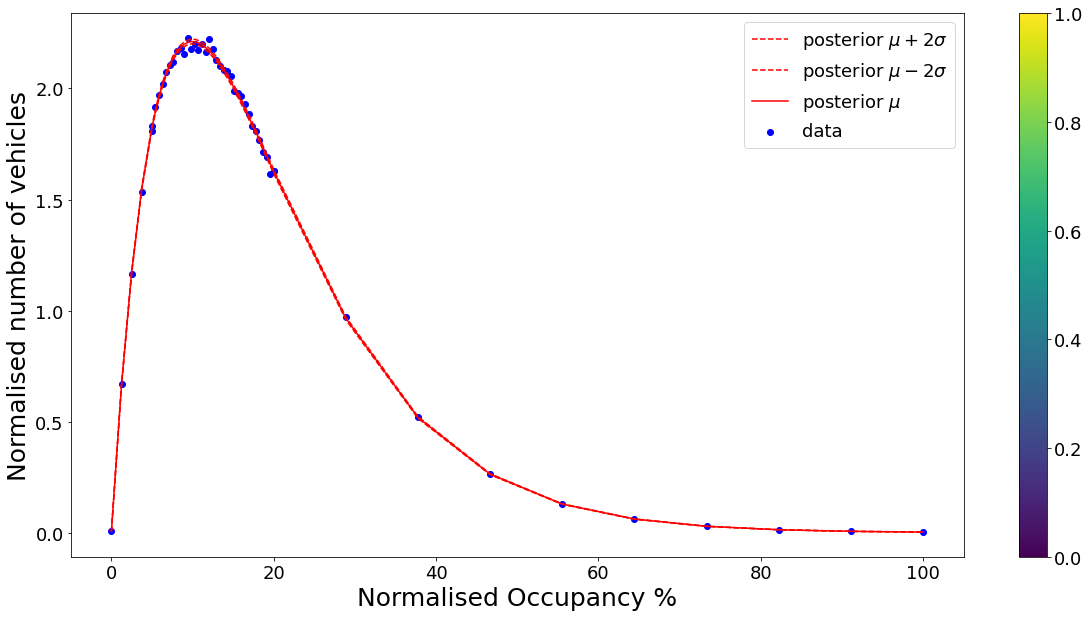

In [254]:
plt.figure(figsize=(20,10))
plt.scatter(rho,q,label='data',color='blue')
plt.plot(rho,q_hat_upper_bound,label=r'posterior $\mu+2\sigma$',color='red',linestyle='dashed')
plt.plot(rho,q_hat_lower_bound,label=r'posterior $\mu-2\sigma$',color='red',linestyle='dashed')
plt.plot(rho,q_hat_mean,label=r'posterior $\mu$',color='red')
plt.ylabel('Normalised number of vehicles',fontsize=25)
plt.xlabel('Normalised Occupancy %',fontsize=25)
plt.colorbar()
plt.legend()

# if export_data: plt.savefig(base_url+method+'/'+filename+'_data_fit.png')

### Posterior predictive computation

In [255]:
import time

In [25]:
def exponential_fd_given_rho(p,r):
    return p[0]*r*np.exp(-p[1]*r)

def exponential_fd_log_likelihood(p,y):
#     print('p',p[:-1])
    return np.sum([ss.lognorm.logpdf(y[i],s=np.sqrt(p[-1]),scale=exponential_fd(p[:-1])[i]) for i in range(y.shape[0])])

def exponential_fd_predictive_log_likelihood(p,y,x):
    return np.sum([ss.lognorm.logpdf(y,s=np.sqrt(p[-1]),scale=exponential_fd_given_rho(p,x[i])) for i in range(x.shape[0])])

def exponential_fd_log_likelihood_sample(p,x):
    return np.array([np.random.lognormal(mean=np.log(exponential_fd_given_rho(p,x[i])),sigma=np.sqrt(p[-1])) for i in range(x.shape[0])])

def exponential_fd_log_likelihood_sample_squared(p,x):
    return np.array([np.random.lognormal(mean=np.log(exponential_fd_given_rho(p,x[i])),sigma=np.sqrt(p[-1]))**2 for i in range(x.shape[0])])

def posterior_predictive_moments(samples,y,x):
    np.random.seed(2021)
    pp_y = np.zeros(y.shape[0])
    pp_y_squared = np.zeros(y.shape[0])
    for j in tqdm(range(samples.shape[0])):
        pp_y += exponential_fd_log_likelihood_sample(samples[j,:],x)
        pp_y_squared += exponential_fd_log_likelihood_sample_squared(samples[j,:],x)
        
    pp_mean = pp_y/samples.shape[0]
    pp_std = pp_y_squared/samples.shape[0] - pp_mean**2
    return pp_mean,pp_std

def posterior_predictive_moments_fast(samples,y,x):
    np.random.seed(2021)
    tic = time.perf_counter()    
    pp = np.array([exponential_fd_log_likelihood_sample(samples[j,:],x) for j in range(burnin,samples.shape[0])])
    pp_mean = np.mean(pp,axis=0)
    pp_var = np.mean(pp**2,axis=0) - pp_mean**2
    
    toc = time.perf_counter()
    print(f"Computed posterior predictive in {toc - tic:0.4f} seconds")
    return pp_mean,np.sqrt(pp_var)

In [257]:
# grw_posterior_predictive_mean,grw_posterior_predictive_std = posterior_predictive_moments(grw_mcmc_parameters[burnin:,:],q,rho)

grw_posterior_predictive_fast_mean,grw_posterior_predictive_fast_std = posterior_predictive_moments_fast(grw_mcmc_parameters,q,rho)


Computed posterior predictive in 2.5739 seconds


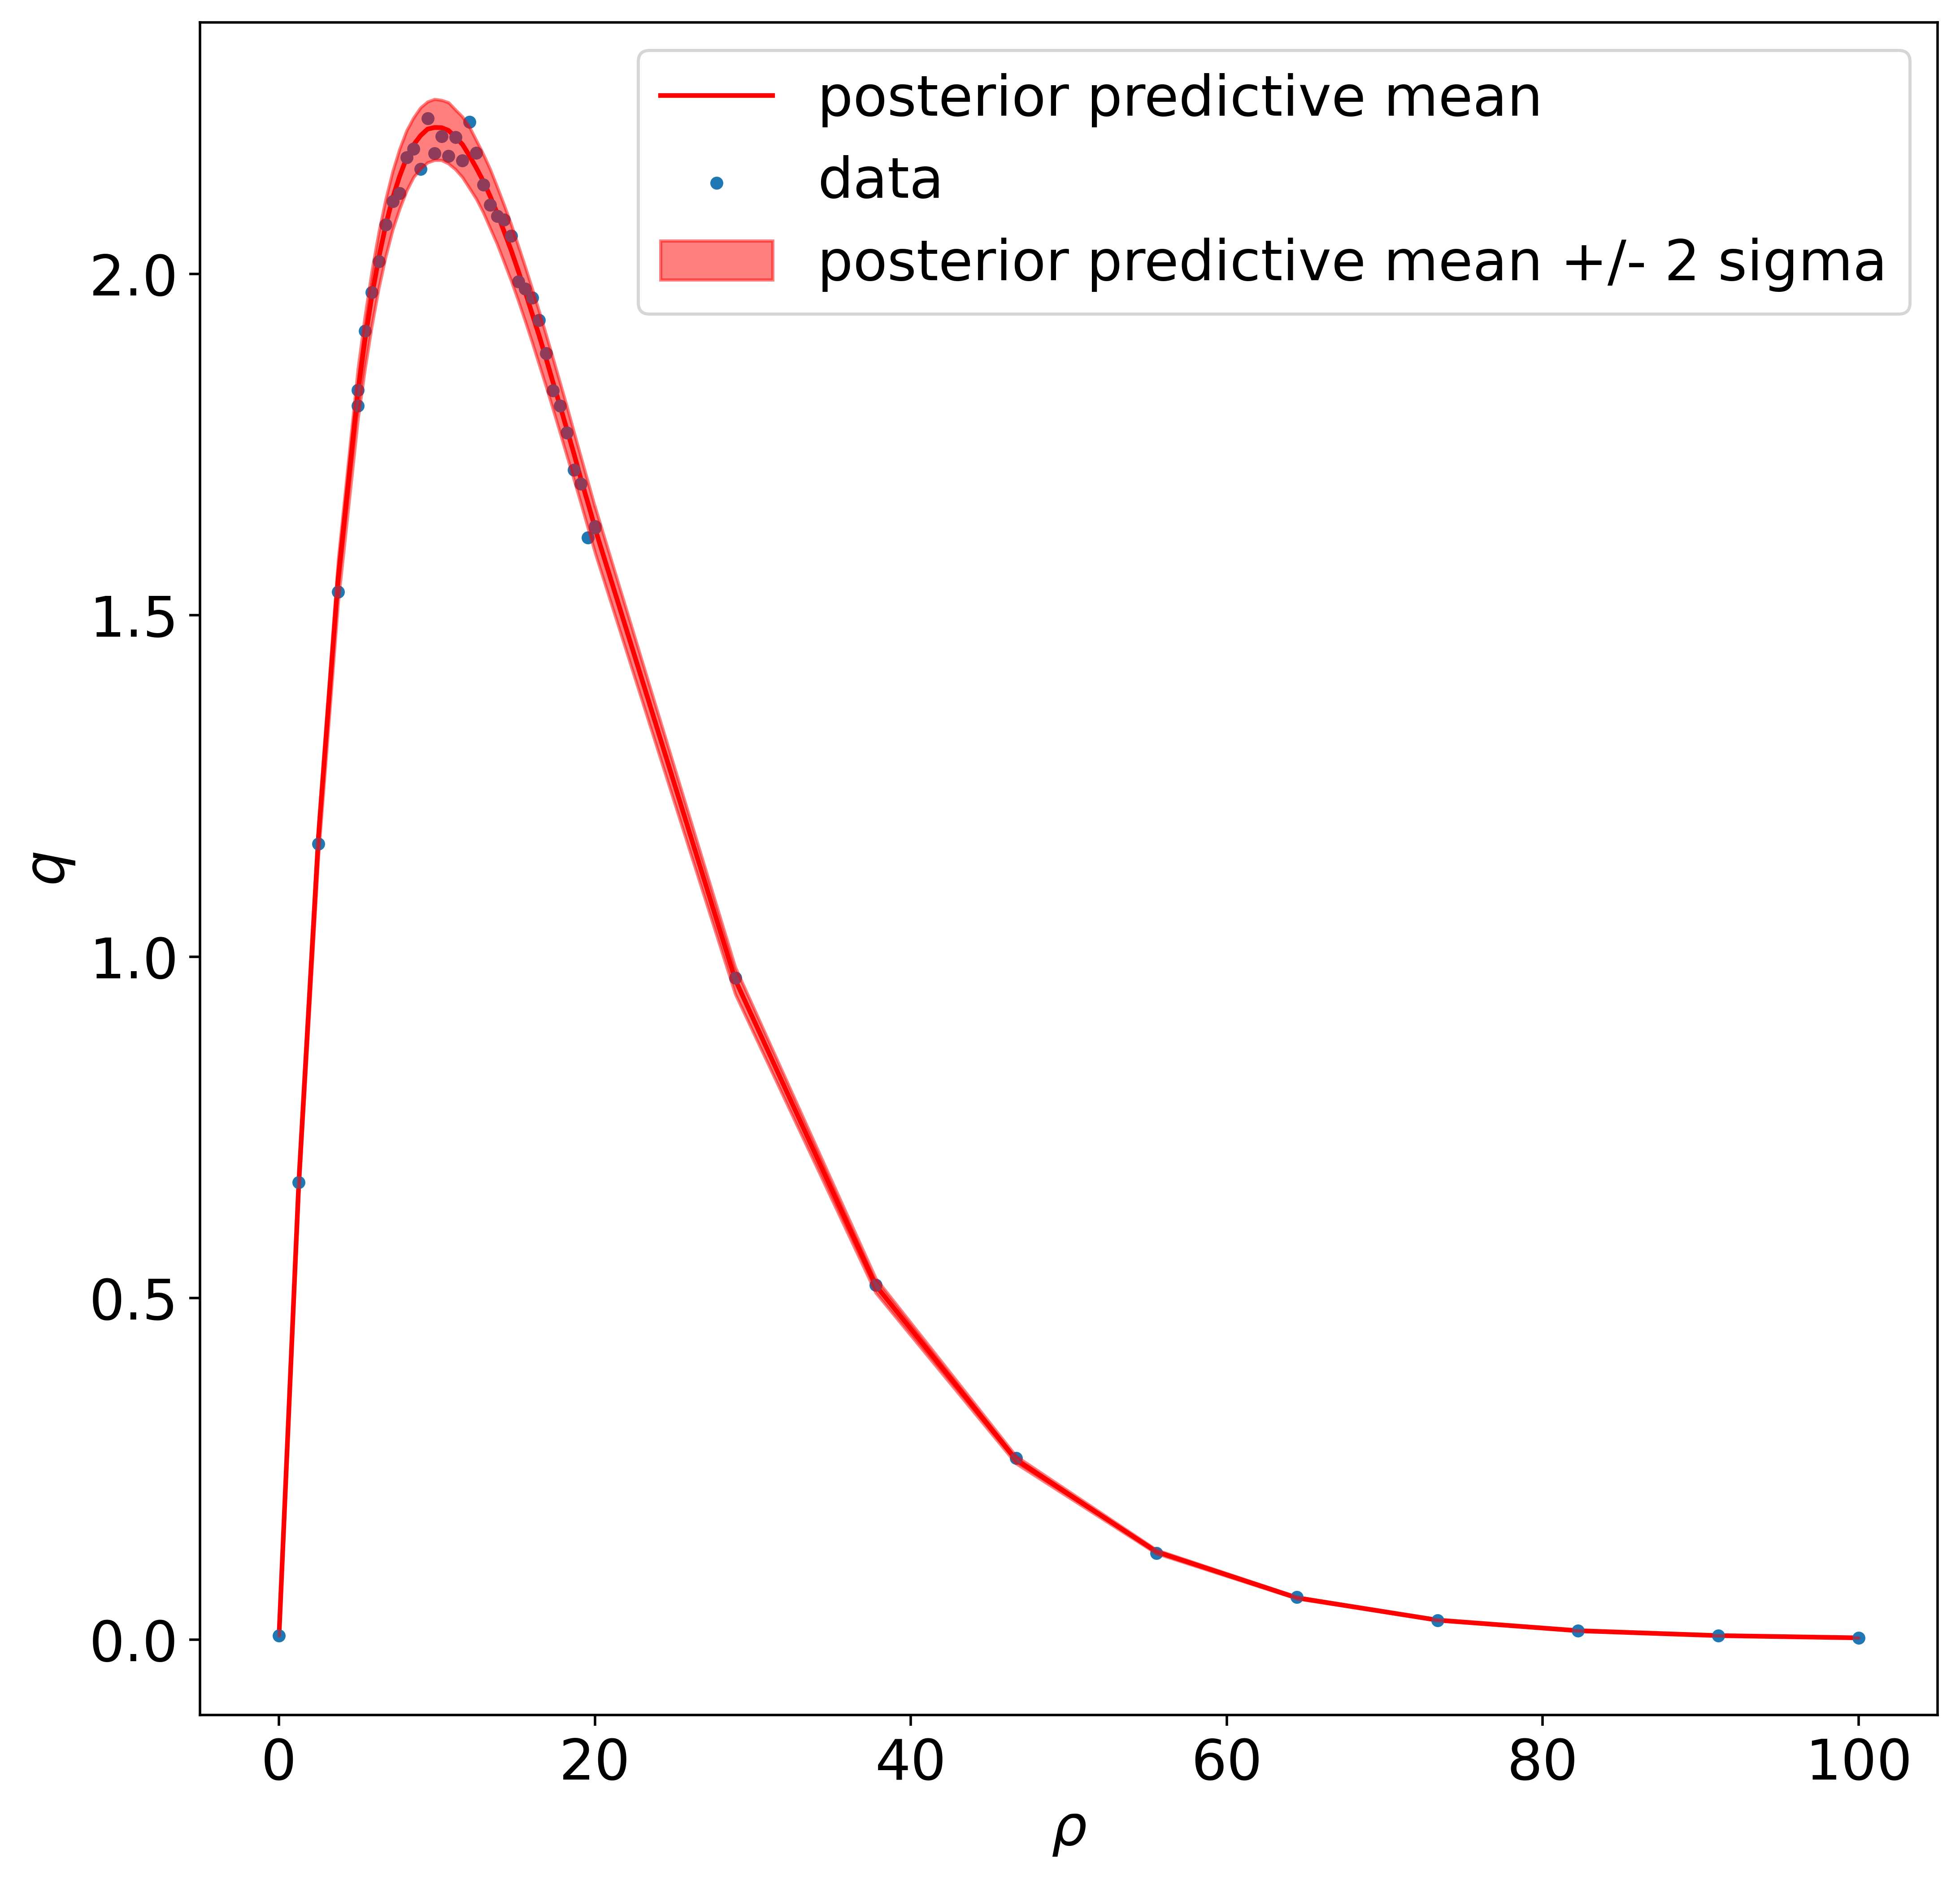

In [258]:
q_upper = grw_posterior_predictive_fast_mean + 2 * grw_posterior_predictive_fast_std
q_lower = grw_posterior_predictive_fast_mean - 2 * grw_posterior_predictive_fast_std


plt.figure(figsize=(10,10),dpi=500)
plt.scatter(rho,q,label='data',zorder=2,s=10)
plt.fill_between(rho,q_upper,q_lower,alpha=0.5,color='red',zorder=3,label='posterior predictive mean +/- 2 sigma')
# plt.plot(rho,q_lower,color='r',label=f'posterior predictive mean + 2sd')
plt.plot(rho,grw_posterior_predictive_mean,color='red',label='posterior predictive mean',zorder=1)
# plt.plot(rho,q_upper,color='r',label=f'posterior predictive mean - 2sd')
plt.xlabel(r'$\rho$')
plt.ylabel(r'$q$')
plt.legend()

### Marginal likelihood estimation

We use the posterior harmonic mean of the likelihood values i.e.

$$Z = \left[\frac{1}{N} \sum_{i=1}^N p(\mathbf{y}|\theta^{(i)})^{-1}\right]^{-1}$$

or equivalently

$$\log(Z) = -\log\left(-\log(N) -\log(\sum_{i=1}^N p(\mathbf{y}|\theta^{(i)}))\right)$$

In [261]:
def exponential_fd_log_likelihood(p,y):
#     print('p',p[:-1])
    return np.sum([ss.lognorm.logpdf(y[i],s=np.sqrt(p[-1]),scale=exponential_fd(p[:-1])[i]) for i in range(y.shape[0])])

def log_posterior_harmonic_mean(param_posterior):
    # Get number of MCMC iterations
    _N = param_posterior.shape[0]
    # Initialise marginal likelihood
#     ml = _N*(np.sum([np.exp(evaluate_log_likelihood(param_posterior[i,:]))**(-1) for i in range(_N)]))**(-1)
    ml = 0
    for i in tqdm(range(burnin,_N)):
        term = np.exp(exponential_fd_log_likelihood(param_posterior[i,:],q))**(-1)
#         print(q)
#         print('param posterior',param_posterior[i,:])
#         print('term',term)
#         sys.exit(1)
        if ~np.isfinite(term):
            print(term)
        ml += term
        
    return _N * (ml)**(-1)
    

In [262]:
ml = log_posterior_harmonic_mean(grw_mcmc_parameters)

100%|██████████| 8000/8000 [01:24<00:00, 95.17it/s] 


In [263]:
print("Marginal likelihood:",ml)
print("Log marginal likelihood:",np.log(ml))

Marginal likelihood: 8.958907796750443e+70
Log marginal likelihood: 163.37360483145582


# Thermodynamic integration MCMC
## Load data

In [125]:
burnin = 2000
data_id = "exponential_fd_simulation_small"
inference_id = "grwmh_inference_wide_gamma_priors_sigma2_fixed"
file = f"/Users/Yannis/code/probabilistic_traffic_flow_modelling/data/output/fundamental_diagram_data/{data_id}/rho.txt"
rho = np.loadtxt(file)
file = f"/Users/Yannis/code/probabilistic_traffic_flow_modelling/data/output/fundamental_diagram_data/{data_id}/q.txt"
q = np.loadtxt(file)
file = f"/Users/Yannis/code/probabilistic_traffic_flow_modelling/data/input/simulation_parameters/{data_id}.toml"
simulation_metadata  = toml.load(file)
sigma2 = float(simulation_metadata['true_parameters']['sigma2'])
file = f"/Users/Yannis/code/probabilistic_traffic_flow_modelling/data/input/inference_parameters/{inference_id}.toml"
inference_metadata  = toml.load(file)

prior_a_alpha_param = float(inference_metadata['inference']['priors']['alpha']['a'])
prior_b_alpha_param = float(inference_metadata['inference']['priors']['alpha']['scale'])
prior_a_beta_param = float(inference_metadata['inference']['priors']['beta']['a'])
prior_b_beta_param = float(inference_metadata['inference']['priors']['beta']['scale'])

K = np.diag(list(inference_metadata['inference']['thermodynamic_integration_mcmc']['transition_kernel']['K_diagonal']))
beta_step = float(inference_metadata['inference']['thermodynamic_integration_mcmc']['transition_kernel']['beta_step'])


In [64]:
np.random.seed(2021)

# Uniform geometric-based temperature schedule
def uniform_t(_n):
    return np.array([i/(_n-1) for i in range(0,_n)]).reshape((_n))

# Prior geometric-based temperature schedule
def prior_t(_n,_p):
    return np.array([(i/(_n-1))**_p for i in range(0,_n)]).reshape((_n))

# Posterior geometric-based temperature schedule
def posterior_t(_n,_p):
    return np.array([(1-(i/(_n-1))**_p) for i in range(0,_n)]).reshape((_n))

def exponential_fd_log_prior(p):
    return ss.gamma.logpdf(p[0],prior_a_alpha_param,scale=prior_b_alpha_param)\
            + ss.gamma.logpdf(p[1],prior_a_beta_param,scale=prior_b_beta_param)#\
            #+ ss.gamma.logpdf(p[2],a=gamma_prior_a_sigma_param,scale=gamma_prior_b_sigma_param)
    
def exponential_fd_log_likelihood(p):
#     print('p',p[:-1])
    return np.sum([ss.lognorm.logpdf(q[i],s=np.sqrt(sigma2),scale=exponential_fd(p)[i]) for i in range(q.shape[0])])

def exponential_fd_log_target_t(p,temp,t):
    # Log target is sum of priors and likelihood for each temperature
    return exponential_fd_log_prior(p[t,:]) + temp[t]*exponential_fd_log_likelihood(p[t,:])

def gaussian_transition_kernel_t(p_prev):
    # Propose move
    return p_prev + beta_step*np.random.multivariate_normal(np.zeros(p_prev.shape[0]),K)

In [72]:
temperature_schedule = prior_t(20,5)

p0 = np.array(list([0.4, 0.2]))
p0 = np.repeat([p0],len(temperature_schedule),axis=0)

In [73]:
exponential_fd_log_target_t(p0,temperature_schedule,0)

0.8285917904853344

In [74]:
gaussian_transition_kernel_t(p0[0,:])

NameError: name 'K' is not defined

# Log marginal likelihood estimation from thermodynamic integration
## Load data

In [75]:
data_id = "exponential_fd_simulation_small"
inference_id = "grwmh_inference_wide_gamma_priors_sigma2_fixed_small"

file = f"/Users/Yannis/code/probabilistic_traffic_flow_modelling/data/output/fundamental_diagram_data/{data_id}/rho.txt"
rho = np.loadtxt(file)
file = f"/Users/Yannis/code/probabilistic_traffic_flow_modelling/data/output/fundamental_diagram_data/{data_id}/q.txt"
q = np.loadtxt(file)
file = f"/Users/Yannis/code/probabilistic_traffic_flow_modelling/data/input/simulation_parameters/{data_id}.toml"
simulation_metadata  = toml.load(file)
sigma2 = float(simulation_metadata['true_parameters']['sigma2'])
file = f"/Users/Yannis/code/probabilistic_traffic_flow_modelling/data/output/inference_data/{data_id}/grwmh/{inference_id}/thermodynamic_integration/thermodynamic_integration_theta.txt"
grwmh_thermondynamic_samples = np.loadtxt(file)
file = f"/Users/Yannis/code/probabilistic_traffic_flow_modelling/data/input/inference_parameters/{inference_id}.toml"
inference_metadata  = toml.load(file)

N = int(inference_metadata['inference']['thermodynamic_integration_mcmc']['N'])
temp_nsteps = int(inference_metadata['inference']['thermodynamic_integration_mcmc']['temp_nsteps'])
temp_power = float(inference_metadata['inference']['thermodynamic_integration_mcmc']['temp_power'])

prior_a_alpha_param = float(inference_metadata['inference']['priors']['alpha']['a'])
prior_b_alpha_param = float(inference_metadata['inference']['priors']['alpha']['scale'])
prior_a_beta_param = float(inference_metadata['inference']['priors']['beta']['a'])
prior_b_beta_param = float(inference_metadata['inference']['priors']['beta']['scale'])

grwmh_thermondynamic_samples = grwmh_thermondynamic_samples.reshape((N,temp_nsteps,2))
grwmh_thermondynamic_samples = np.dstack((grwmh_thermondynamic_samples,(np.ones((grwmh_thermondynamic_samples.shape[0],grwmh_thermondynamic_samples.shape[1],1))*sigma2)))

# Compute log marginal likelihood

The log marginal likelihood is equal to 
$$
\begin{align}
\log(p(\mathbf{y})) &= \frac{1}{2}\sum_{i=1}^n  \left( \mathbb{E}_{\theta|\mathbf{y},t_{i-1}}\left[\log(p(\mathbf{y}|\theta)\right] + \mathbb{E}_{\theta|\mathbf{y},t_i}\left[\log(p(\mathbf{y}|\theta)\right]\right)(t_i-t_{i-1}) + \frac{1}{2}\sum_{i=1}^n \left[KL(p_{i-1}||p_i)-KL(p_i||p_{i-1})\right]\\
&\approx  \frac{1}{2N}\sum_{i=1}^n \sum_{j=1}^N \left[\log(p(\mathbf{y}|\theta_i^{(j)}) + \log(p(\mathbf{y}|\theta_{i-1}^{(j)}) \right] \Delta t
\end{align}
$$

where $\theta_i^{(j)}$ are samples from the population MCMC-inferred posterior $p(\theta|\mathbf{y},t_i)$ and $KL(p_n||p_{n-1}) = \int p(\theta|\mathbf{y},t_n) \log\left(\frac{p(\theta|\mathbf{y},t_n)}{p(\theta|\mathbf{y},t_{n-1})}\right) d \theta$


In [76]:
burnin = 50000

In [77]:
def exponential_fd_log_prior(p):
    return ss.gamma.logpdf(p[0],prior_a_alpha_param,scale=prior_b_alpha_param)\
            + ss.gamma.logpdf(p[1],prior_a_beta_param,scale=prior_b_beta_param)#\
            #+ ss.gamma.logpdf(p[2],a=gamma_prior_a_sigma_param,scale=gamma_prior_b_sigma_param)
    
def exponential_fd_log_likelihood(p):
#     print('p',p[:-1])
    return np.sum([ss.lognorm.logpdf(q[i],s=np.sqrt(sigma2),scale=exponential_fd(p)[i]) for i in range(q.shape[0])])


def exponential_fd_log_marginal_likelihood(learned_params,temp_schedule):
    
    # Store length of temperature schedule
    t_len = temp_schedule.shape[0]
    
    # Get number of MCMC iterations
    num_iters = learned_params.shape[0]
    
    # Initiliase lml 
    lml = 0    
#     return np.sum([(temp_schedule[ti] - temp_schedule[ti-1]) * np.sum([exponential_fd_log_likelihood(learned_params[j,:,:],ti,y,sigma_2) for ti in range(1,t_len) for j in range(num_iters)])])
    
    # Loop temperature indices
    for ti in tqdm_notebook(range(1,t_len)):
        # Compute Delta t
        delta_t = temp_schedule[ti] - temp_schedule[ti-1]
#         print('delta_t',delta_t)
        # Loop through each iteration
        for j in tqdm_notebook(range(burnin,num_iters), leave=False):
            term1 = exponential_fd_log_likelihood(learned_params[j,ti,:])
            term2 = exponential_fd_log_likelihood(learned_params[j,ti-1,:])
#             print('j =',j)
#             print('learned_params[j,ti,:]',learned_params[j,ti,:])
#             print('deltat',delta_t)
#             print('term1',term1)
#             print('term2',term2)
#             sys.exit(1)
            # Compute posterior expectation
            lml += delta_t*(term1+term2)
    
    return lml/(2*(num_iters-burnin))

In [78]:
temperature_schedule = prior_t(temp_nsteps,temp_power)
grwmh_thermondynamic_lml = exponential_fd_log_marginal_likelihood(grwmh_thermondynamic_samples,temperature_schedule)

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [152]:
print('Thermodynamic integration log marginal likelihood estimate:',grwmh_thermondynamic_lml)

Thermodynamic integration log marginal likelihood estimate: 115.0402537726931


# Proposal choice

In [48]:
K_diag = [0.01,0.001]
beta_step = 0.01
num_samples = 100000

In [49]:
proposal_samples = beta_step * np.random.multivariate_normal(np.zeros(2),np.diag(K_diag),num_samples)

mu 1.3993353086185488e-06
sd 0.0009988565172665657
mu + 2sd 0.00199911236984175
mu - 2sd -0.001996313699224513
mu + sd 0.0010002558525751843
mu - sd -0.0009974571819579472


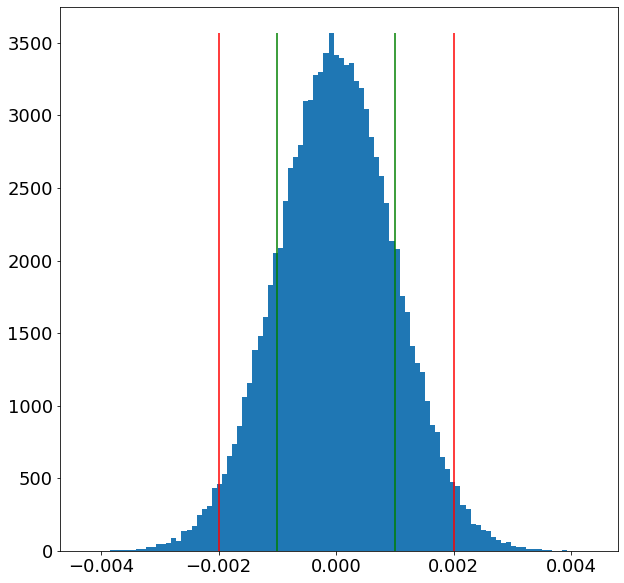

In [53]:
print('mu',(np.mean(proposal_samples[:,0])))
print('sd',(np.std(proposal_samples[:,0])))
print('mu + 2sd',(np.mean(proposal_samples[:,0])+2*np.std(proposal_samples[:,0])))
print('mu - 2sd',(np.mean(proposal_samples[:,0])-2*np.std(proposal_samples[:,0])))
print('mu + sd',(np.mean(proposal_samples[:,0])+np.std(proposal_samples[:,0])))
print('mu - sd',(np.mean(proposal_samples[:,0])-np.std(proposal_samples[:,0])))

plt.figure(figsize=(10,10))
freq = plt.hist(proposal_samples[:,0],bins=100)
plt.vlines(x=(np.mean(proposal_samples[:,0])+2*np.std(proposal_samples[:,0])),ymin=0,ymax=np.max(freq[0]),color='red')
plt.vlines(x=(np.mean(proposal_samples[:,0])-2*np.std(proposal_samples[:,0])),ymin=0,ymax=np.max(freq[0]),color='red')
plt.vlines(x=(np.mean(proposal_samples[:,0])+1*np.std(proposal_samples[:,0])),ymin=0,ymax=np.max(freq[0]),color='green')
plt.vlines(x=(np.mean(proposal_samples[:,0])-1*np.std(proposal_samples[:,0])),ymin=0,ymax=np.max(freq[0]),color='green')
plt.show()

mu 3.7299196672233304e-08
sd 0.00031813672016599537
mu + 2sd 0.000636310739528663
mu - 2sd -0.0006362361411353185
mu + sd 0.0003181740193626676
mu - sd -0.0003180994209693231


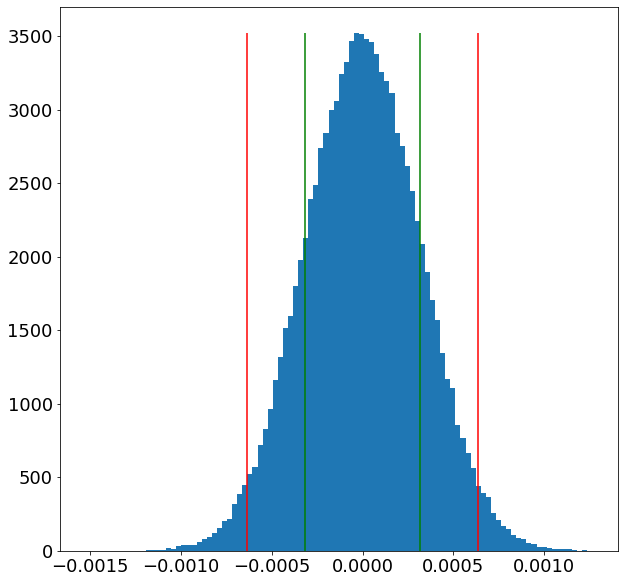

In [54]:
print('mu',(np.mean(proposal_samples[:,1])))
print('sd',(np.std(proposal_samples[:,1])))
print('mu + 2sd',(np.mean(proposal_samples[:,1])+2*np.std(proposal_samples[:,1])))
print('mu - 2sd',(np.mean(proposal_samples[:,1])-2*np.std(proposal_samples[:,1])))
print('mu + sd',(np.mean(proposal_samples[:,1])+np.std(proposal_samples[:,1])))
print('mu - sd',(np.mean(proposal_samples[:,1])-np.std(proposal_samples[:,1])))

plt.figure(figsize=(10,10))
freq = plt.hist(proposal_samples[:,1],bins=100)
plt.vlines(x=(np.mean(proposal_samples[:,1])+2*np.std(proposal_samples[:,1])),ymin=0,ymax=np.max(freq[0]),color='red')
plt.vlines(x=(np.mean(proposal_samples[:,1])-2*np.std(proposal_samples[:,1])),ymin=0,ymax=np.max(freq[0]),color='red')
plt.vlines(x=(np.mean(proposal_samples[:,1])+1*np.std(proposal_samples[:,1])),ymin=0,ymax=np.max(freq[0]),color='green')
plt.vlines(x=(np.mean(proposal_samples[:,1])-1*np.std(proposal_samples[:,1])),ymin=0,ymax=np.max(freq[0]),color='green')
plt.show()

# Compute Gelman and Rubin criterion

In [350]:
def gelman_rubin_statistic(posterior_samples):
    _n = posterior_samples[burnin:,:,:].shape[0]
    _t_len = len(temperature_schedule)
    
    temp = np.array([np.std(posterior_samples[burnin:,ti,:],axis=1)**2 for ti in range(_t_len)])
    print(np.mean(temp,axis=0))
    _W = np.mean([np.std(posterior_samples[burnin:,ti,:],axis=0)**2 for ti in range(_t_len)],axis=0)
    print(_W)
    chain_means = np.mean(posterior_samples[burnin:,:,:],axis=0)
    chain_mean = np.mean(chain_means,axis=0)
    _B = _n * np.sum([(chain_means[i,:]-chain_mean)**2 for i in range(_t_len)])
    print(_B)
    _var_theta = (1 - 1/_n) * _W + 1/_n*_B
    print("Gelman-Rubin Diagnostic: ", np.sqrt(_var_theta/_W))

In [349]:
gelman_rubin_statistic(grwmh_thermondynamic_samples)

[0.02737549 0.02737544 0.02737544 ... 0.03312323 0.033123   0.03312194]
[1.15958818e-04 2.16446363e-04 8.04927104e-35]
9.217267668786226
Gelmen-Rubin Diagnostic:  [3.30693255e+00 2.51454605e+00 3.78336142e+15]


### Adding constants to parameter posterior mean and std (useless)

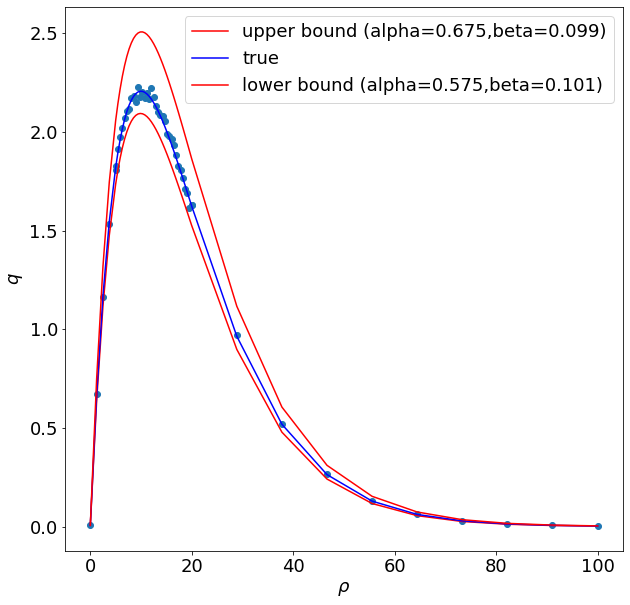

In [130]:
alpha_upper = 0.675#np.max(grw_mcmc_parameters[burnin:,:],axis=0)[0] + 0.05
beta_upper = 0.101#np.max(grw_mcmc_parameters[burnin:,:],axis=0)[1] + 0.01

alpha_lower = 0.575#np.min(grw_mcmc_parameters[burnin:,:],axis=0)[0] - 0.05
beta_lower = 0.099#np.min(grw_mcmc_parameters[burnin:,:],axis=0)[1] - 0.01
    
q_upper = exponential_fd([alpha_upper,beta_lower])
q_lower = exponential_fd([alpha_lower,beta_upper])

plt.figure(figsize=(10,10))
plt.scatter(rho,q)
plt.plot(rho,q_lower,color='r',label=f'upper bound (alpha={alpha_upper},beta={beta_lower})')
plt.plot(rho,q_true,color='b',label='true')
plt.plot(rho,q_upper,color='r',label=f'lower bound (alpha={alpha_lower},beta={beta_upper})')
plt.xlabel(r'$\rho$')
plt.ylabel(r'$q$')
plt.legend()
plt.ioff()

### Export data

In [131]:
# Flag for exporting data
export_data = True

In [132]:
if export_data:
    # Export MCMC chains
    np.savetxt(base_url+method+'/'+filename+'.txt',grw_mcmc_parameters)
    np.savetxt(base_url+method+'/'+filename+'_proposals.txt',grw_mcmc_parameters)
    
    # Compile metadata
    grw_posterior_metadata = {}
    grw_posterior_metadata['acceptance'] = grw_mcmc_acceptance
    grw_posterior_metadata['gelman_rubin_statistic'] = grw_mcmc_gelman_rubin_statistic
#     grw_posterior_metadata['log_marginal_likelihood'] = exponential_fd_lml
    grw_posterior_metadata['N'] = N
    grw_posterior_metadata['true_alpha'] = alpha
    grw_posterior_metadata['true_beta'] = beta
    grw_posterior_metadata['beta_step'] = beta_step
    grw_posterior_metadata['beta_prior_alpha_param'] = {'a':beta_prior_a_alpha_param,'b':beta_prior_b_alpha_param}
    grw_posterior_metadata['beta_prior_beta_param'] = {'a':beta_prior_a_beta_param,'b':beta_prior_b_beta_param}
    grw_posterior_metadata['gamma_prior_sigma_param'] = {'a':gamma_prior_a_sigma_param,'b':gamma_prior_b_sigma_param}
    grw_posterior_metadata['initial_parameters'] = list(parameters_init)
    grw_posterior_metadata['proposal_variances'] = list(np.diag(proposal_covariance))

    # Export metadata
#     print(json.dumps(grw_posterior_metadata,indent=2))

    with open(base_url+method+'/'+filename+'_metadata.json', 'w') as outfile:
        json.dump(grw_posterior_metadata, outfile)

FileNotFoundError: [Errno 2] No such file or directory: '../data/output/models/synthetic/exponential_fd/grwmh_mcmc/grw_parameter_posterior_fixed_sigma2_0,0001_test.txt'